In [ ]:
# All imports
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import inspect
from tqdm import tqdm
from fastai.imports import *
from fastai.vision.all import *
import tensorflow_datasets as tfds
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import keras.backend as K
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.metrics import SparseCategoricalCrossentropy
from tensorflow import keras
from PIL import Image
from numpy import asarray
from tensorflow.keras.preprocessing import image
from sklearn.model_selection import train_test_split
from google.colab.patches import cv2_imshow
from scipy.io import loadmat 
import cv2
from keras.layers import Flatten
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt

In [ ]:
# Retrieving files from our Google Drive
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
# Unzipping files into colab
!unzip '/content/drive/My Drive/NNDL Project Submission/im.zip'

Streaming output truncated to the last 5000 lines.
  inflating: im/image_06851.jpg      
  inflating: __MACOSX/im/._image_06851.jpg  
  inflating: im/image_07597.jpg      
  inflating: __MACOSX/im/._image_07597.jpg  
  inflating: im/image_06689.jpg      
  inflating: __MACOSX/im/._image_06689.jpg  
  inflating: im/image_01680.jpg      
  inflating: __MACOSX/im/._image_01680.jpg  
  inflating: im/image_01858.jpg      
  inflating: __MACOSX/im/._image_01858.jpg  
  inflating: im/image_03097.jpg      
  inflating: __MACOSX/im/._image_03097.jpg  
  inflating: im/image_02389.jpg      
  inflating: __MACOSX/im/._image_02389.jpg  
  inflating: im/image_04920.jpg      
  inflating: __MACOSX/im/._image_04920.jpg  
  inflating: im/image_03083.jpg      
  inflating: __MACOSX/im/._image_03083.jpg  
  inflating: im/image_04934.jpg      
  inflating: __MACOSX/im/._image_04934.jpg  
  inflating: im/image_01694.jpg      
  inflating: __MACOSX/im/._image_01694.jpg  
  inflating: im/image_06845.jpg     

In [ ]:
# Input for the labels of our images
labels = '/content/drive/My Drive/NNDL Project/imagelabels.mat'
image_labels = loadmat(labels)
image_labels.keys()

dict_keys(['__header__', '__version__', '__globals__', 'labels'])

In [ ]:
# Adding our image_labels into a dataframe to match with our images
df = pd.DataFrame()
labels = image_labels['labels'].transpose()
labels = labels -1
df = pd.DataFrame(labels, columns = ['image_label'])

In [ ]:
# Adding our image paths to our image_labels dataframe
image_path = []
for i in range (1,len(labels)+1):
  if i<10:
    x = '0000' + str(i)
  elif i<100:
    x = '000' + str(i)
  elif i<1000:
    x = '00' + str(i)
  elif i<10000:
    x = '0' + str(i)
  else:
    break
  image_path.append('/content/im/image_'+x+'.jpg')

df["image_path"] = image_path 

In [ ]:
# Checking how many images we have per class (top few and bottom few to understand the distributioin of samples)
df.image_label.value_counts()

50    258
76    251
45    196
72    194
88    184
     ... 
6      40
44     40
33     40
0      40
26     40
Name: image_label, Length: 102, dtype: int64

In [ ]:
# Test to see whether the path code works to open the 1st image
im = Image.open(df['image_path'][0])
width, height = im.size
print(width,height)

591 500


In [ ]:
# Function to load images, convert to numpy array of pixel data, split into train test split, convert to a tensor and return. (Based on img_size input)
def split_function(train_df,img_size):
  data = train_df.copy()
  img_size = img_size
  train_image = []
  for i in tqdm(range(data.shape[0])):
    # inputting images with the required input size
    img = image.load_img(data['image_path'][i],target_size=(img_size,img_size,3))
    img = image.img_to_array(img)
    train_image.append(img)
  # appending the image arrays to a new numpy array
  train_df = np.array(train_image)
  image_label = data['image_label'].to_numpy()
  # train, test split (0.7, 0.3)
  X_train, X_test, y_train, y_test = train_test_split(train_df, image_label, random_state=42, test_size=0.3, stratify = image_label)

  print('Number of training samples ', len(y_train))
  print('Number of testing samples ', len(y_test))
  
  return(X_train, y_train)

In [ ]:
# Function to load images, convert to numpy array of pixel data, split into train test split, convert to a tensor and return. (Based on img_size input)
def split_function_ds(train_df,img_size):

    data = train_df.copy()
    img_size = img_size
    train_image = []
    for i in tqdm(range(data.shape[0])):
      # inputting images with the required input size
      img = image.load_img(data['image_path'][i],target_size=(img_size,img_size,3))
      img = image.img_to_array(img)
      train_image.append(img)
    # appending the image arrays to a new numpy array
    train_df = np.array(train_image)
    image_label = data['image_label'].to_numpy()
    # train, val, test split (0.7, 0.2, 0.1)
    X_train, X_test, y_train, y_test = train_test_split(train_df, image_label, random_state=42, test_size=0.3, stratify = image_label)
    X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, random_state=42, test_size=0.33, stratify = y_test)

    train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
    val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val))

    print('Number of training samples ', len(train_ds))
    print('Number of validation samples ', len(val_ds))

    # Batching and applying prefetching for faster processing
    train_ds = train_ds.cache().batch(32).prefetch(buffer_size = tf.data.experimental.AUTOTUNE)
    val_ds = val_ds.cache().batch(32).prefetch(buffer_size = tf.data.experimental.AUTOTUNE)

    print('Number of training samples after batching ', len(train_ds))
    print('Number of validation samples after batching ', len(val_ds))
    
    return(train_ds, val_ds)

In [ ]:
X_train, Y_train = split_function(df, 224)

100%|██████████| 8189/8189 [00:39<00:00, 205.25it/s]


Number of training samples  5732
Number of testing samples  2457


In [ ]:
train_ds, val_ds = split_function_ds(df,224)

100%|██████████| 8189/8189 [01:11<00:00, 113.87it/s]


Number of training samples  5732
Number of validation samples  1646
Number of training samples after batching  180
Number of validation samples after batching  52


In [ ]:
# Using one model to conduct our fine tuning experiments
model = tf.keras.applications.efficientnet_v2.EfficientNetV2B2

preprocess_func = tf.keras.applications.efficientnet_v2.preprocess_input

In [ ]:
# Early stopping implementation to reduce over fitting
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Initialising our augmentation layer
data_augmentation = tf.keras.Sequential([
  keras.layers.RandomFlip("horizontal_and_vertical"),
  keras.layers.RandomRotation(0.2),
])

In [ ]:
def create_model(num_neuron):
   # Creating a new model on top
  inputs = tf.keras.layers.Input(shape=input_shape)
  
  #  Float casting
  x = tf.cast(inputs, tf.float32)

  # Data Augmentation 
  x = data_augmentation(x)

  # Default Preprocess Function for our Pre-trained Models
  x = preprocess_func(x)
  
  # Creating our base model
  base_model = model(weights="imagenet", 
                      include_top=False, 
                      input_shape=input_shape)
  # Frezing the base_model weights
  base_model.trainable = False
    
  # Building the model
  x = base_model(x, training = False)
  x = tf.keras.layers.GlobalAveragePooling2D()(x)
  x = tf.keras.layers.Dropout(0.2)(x)
  x = tf.keras.layers.Dense(num_neuron, activation='relu')(x)
  x = tf.keras.layers.Dropout(0.2)(x)
  outputs = tf.keras.layers.Dense(102, activation='softmax')(x)
  reg_model = tf.keras.Model(inputs, outputs)
  return reg_model

In [ ]:
input_shape = (224, 224, 3)

In [ ]:
# Training our model wihtout any new additional dense layers to get the graphs for accuracy and loss

# Creating a new model on top
inputs = tf.keras.layers.Input(shape=input_shape)

#  Float casting
x = tf.cast(inputs, tf.float32)

# Data Augmentation 
x = data_augmentation(x)

# Default Preprocess Function for our Pre-trained Models
x = preprocess_func(x)

# Creating our base model
base_model = model(weights="imagenet", 
                    include_top=False, 
                    input_shape=input_shape)
# Frezing the base_model weights
base_model.trainable = False
  
# Building the model
x = base_model(x, training = False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)

outputs = tf.keras.layers.Dense(102, activation='softmax')(x)
reg_model = tf.keras.Model(inputs, outputs)

reg_model.compile(optimizer=tf.keras.optimizers.Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
history = reg_model.fit(train_ds, epochs = 20, validation_data=val_ds, callbacks=[es])

35839040/35839040 [==============================] - 1s 0us/step
Epoch 1/20
180/180 [==============================] - 28s 66ms/step - loss: 2.6016 - accuracy: 0.4930 - val_loss: 1.3158 - val_accuracy: 0.7807
Epoch 2/20
180/180 [==============================] - 8s 45ms/step - loss: 1.0217 - accuracy: 0.8358 - val_loss: 0.7575 - val_accuracy: 0.8706
Epoch 3/20
180/180 [==============================] - 8s 45ms/step - loss: 0.6444 - accuracy: 0.8946 - val_loss: 0.5596 - val_accuracy: 0.9034
Epoch 4/20
180/180 [==============================] - 8s 44ms/step - loss: 0.4705 - accuracy: 0.9267 - val_loss: 0.4570 - val_accuracy: 0.9149
Epoch 5/20
180/180 [==============================] - 8s 44ms/step - loss: 0.3726 - accuracy: 0.9398 - val_loss: 0.3949 - val_accuracy: 0.9241
Epoch 6/20
180/180 [==============================] - 8s 45ms/step - loss: 0.3036 - accuracy: 0.9534 - val_loss: 0.3552 - val_accuracy: 0.9277
Epoch 7/20
180/180 [==============================] - 8s 44ms/step - loss: 0

Text(0, 0.5, 'Accuracy')

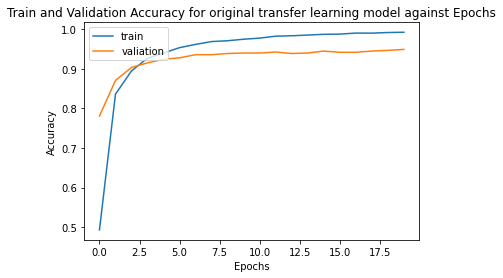

In [ ]:
# With no additional layers accuracy plots
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title('Train and Validation Accuracy for original transfer learning model against Epochs')
plt.legend(['train', 'valiation'], loc = 'upper left')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

Text(0, 0.5, 'Loss')

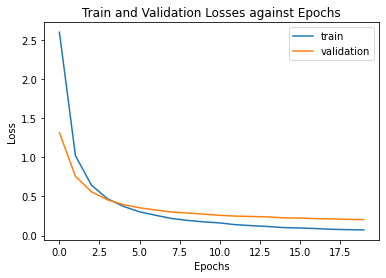

In [ ]:
# With no additional layers loss plots
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Train and Validation Losses against Epochs')
plt.legend(['train', 'validation'], loc = 'upper right')
plt.xlabel('Epochs')
plt.ylabel('Loss')

In [ ]:
# KFold CV to check best number of neurons in the first dense layer
num_neurons = [8, 16, 32, 64, 128, 256, 512, 1024]

kfold = KFold(n_splits = 5, shuffle=True, random_state=42)

mean_accuracy = []

input_shape=(224, 224, 3)

for num_neuron in tqdm(num_neurons):

  print('Running for Number of Neurons :', num_neuron, ' -------------------------')
  cnt = 1
  accuracies = []
  for train_index, val_index in tqdm(kfold.split(X_train, Y_train)):

    x_train, y_train = X_train[train_index], Y_train[train_index]
    x_val, y_val = X_train[val_index], Y_train[val_index]

    train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
    val_ds = tf.data.Dataset.from_tensor_slices((x_val, y_val))

    # Batching and applying prefetching for faster processing
    train_ds = train_ds.cache().batch(32).prefetch(buffer_size = tf.data.experimental.AUTOTUNE)
    val_ds = val_ds.cache().batch(32).prefetch(buffer_size = tf.data.experimental.AUTOTUNE)
      
    reg_model = create_model(num_neuron)
    
    reg_model.compile(optimizer=tf.keras.optimizers.Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    history = reg_model.fit(train_ds, epochs = 30, validation_data=val_ds, callbacks=[es])

    accuracies.append(history.history['val_accuracy'][-1])
  
  mean_accuracy.append(accuracies)


  0%|          | 0/8 [00:00<?, ?it/s]

Running for Number of Neurons : 8  -------------------------



0it [00:00, ?it/s]

Epoch 1/30
144/144 [==============================] - 18s 62ms/step - loss: 4.4496 - accuracy: 0.0526 - val_loss: 4.1268 - val_accuracy: 0.1011
Epoch 2/30
144/144 [==============================] - 6s 45ms/step - loss: 3.8745 - accuracy: 0.1202 - val_loss: 3.4750 - val_accuracy: 0.1979
Epoch 3/30
144/144 [==============================] - 6s 45ms/step - loss: 3.4601 - accuracy: 0.1710 - val_loss: 3.0555 - val_accuracy: 0.2607
Epoch 4/30
144/144 [==============================] - 6s 45ms/step - loss: 3.1635 - accuracy: 0.2170 - val_loss: 2.7446 - val_accuracy: 0.3069
Epoch 5/30
144/144 [==============================] - 6s 45ms/step - loss: 2.9612 - accuracy: 0.2545 - val_loss: 2.5109 - val_accuracy: 0.3636
Epoch 6/30
144/144 [==============================] - 6s 44ms/step - loss: 2.8471 - accuracy: 0.2680 - val_loss: 2.3547 - val_accuracy: 0.4124
Epoch 7/30
144/144 [==============================] - 6s 45ms/step - loss: 2.7132 - accuracy: 0.2977 - val_loss: 2.2157 - val_accuracy: 0.445


1it [03:32, 212.78s/it]

Epoch 1/30
144/144 [==============================] - 17s 62ms/step - loss: 4.3653 - accuracy: 0.0602 - val_loss: 4.0333 - val_accuracy: 0.1160
Epoch 2/30
144/144 [==============================] - 6s 45ms/step - loss: 3.8678 - accuracy: 0.1276 - val_loss: 3.5395 - val_accuracy: 0.1979
Epoch 3/30
144/144 [==============================] - 6s 45ms/step - loss: 3.4956 - accuracy: 0.1658 - val_loss: 3.1552 - val_accuracy: 0.2764
Epoch 4/30
144/144 [==============================] - 6s 45ms/step - loss: 3.2144 - accuracy: 0.2126 - val_loss: 2.8425 - val_accuracy: 0.3688
Epoch 5/30
144/144 [==============================] - 6s 44ms/step - loss: 3.0326 - accuracy: 0.2401 - val_loss: 2.6063 - val_accuracy: 0.4071
Epoch 6/30
144/144 [==============================] - 6s 45ms/step - loss: 2.8895 - accuracy: 0.2661 - val_loss: 2.4314 - val_accuracy: 0.4368
Epoch 7/30
144/144 [==============================] - 6s 45ms/step - loss: 2.7577 - accuracy: 0.2955 - val_loss: 2.2880 - val_accuracy: 0.459


2it [07:02, 211.10s/it]

Epoch 1/30
144/144 [==============================] - 17s 64ms/step - loss: 4.4405 - accuracy: 0.0508 - val_loss: 4.1531 - val_accuracy: 0.1012
Epoch 2/30
144/144 [==============================] - 6s 45ms/step - loss: 3.9208 - accuracy: 0.1143 - val_loss: 3.6273 - val_accuracy: 0.1588
Epoch 3/30
144/144 [==============================] - 6s 45ms/step - loss: 3.5236 - accuracy: 0.1692 - val_loss: 3.2147 - val_accuracy: 0.2400
Epoch 4/30
144/144 [==============================] - 6s 44ms/step - loss: 3.2567 - accuracy: 0.2058 - val_loss: 2.9221 - val_accuracy: 0.3063
Epoch 5/30
144/144 [==============================] - 6s 44ms/step - loss: 3.0627 - accuracy: 0.2386 - val_loss: 2.7230 - val_accuracy: 0.3525
Epoch 6/30
144/144 [==============================] - 6s 45ms/step - loss: 2.9268 - accuracy: 0.2612 - val_loss: 2.5499 - val_accuracy: 0.3839
Epoch 7/30
144/144 [==============================] - 6s 45ms/step - loss: 2.8541 - accuracy: 0.2638 - val_loss: 2.4383 - val_accuracy: 0.407


3it [10:33, 210.98s/it]

Epoch 1/30
144/144 [==============================] - 17s 61ms/step - loss: 4.4161 - accuracy: 0.0473 - val_loss: 4.0797 - val_accuracy: 0.1230
Epoch 2/30
144/144 [==============================] - 6s 45ms/step - loss: 3.8914 - accuracy: 0.1260 - val_loss: 3.4880 - val_accuracy: 0.2443
Epoch 3/30
144/144 [==============================] - 6s 45ms/step - loss: 3.4916 - accuracy: 0.1836 - val_loss: 3.0560 - val_accuracy: 0.3194
Epoch 4/30
144/144 [==============================] - 6s 44ms/step - loss: 3.1809 - accuracy: 0.2194 - val_loss: 2.7227 - val_accuracy: 0.3813
Epoch 5/30
144/144 [==============================] - 6s 45ms/step - loss: 2.9802 - accuracy: 0.2481 - val_loss: 2.4930 - val_accuracy: 0.4180
Epoch 6/30
144/144 [==============================] - 6s 45ms/step - loss: 2.8310 - accuracy: 0.2732 - val_loss: 2.3183 - val_accuracy: 0.4442
Epoch 7/30
144/144 [==============================] - 6s 44ms/step - loss: 2.7292 - accuracy: 0.2920 - val_loss: 2.2013 - val_accuracy: 0.465


4it [14:03, 210.50s/it]

Epoch 1/30
144/144 [==============================] - 17s 62ms/step - loss: 4.4474 - accuracy: 0.0556 - val_loss: 4.1198 - val_accuracy: 0.1379
Epoch 2/30
144/144 [==============================] - 6s 45ms/step - loss: 3.9222 - accuracy: 0.1374 - val_loss: 3.5264 - val_accuracy: 0.2051
Epoch 3/30
144/144 [==============================] - 6s 45ms/step - loss: 3.5074 - accuracy: 0.1849 - val_loss: 3.0882 - val_accuracy: 0.2888
Epoch 4/30
144/144 [==============================] - 6s 45ms/step - loss: 3.2150 - accuracy: 0.2207 - val_loss: 2.7608 - val_accuracy: 0.3595
Epoch 5/30
144/144 [==============================] - 6s 45ms/step - loss: 3.0237 - accuracy: 0.2473 - val_loss: 2.5399 - val_accuracy: 0.3970
Epoch 6/30
144/144 [==============================] - 6s 45ms/step - loss: 2.8605 - accuracy: 0.2734 - val_loss: 2.3648 - val_accuracy: 0.4302
Epoch 7/30
144/144 [==============================] - 6s 45ms/step - loss: 2.7530 - accuracy: 0.2894 - val_loss: 2.2357 - val_accuracy: 0.451


5it [17:34, 210.88s/it]
 12%|█▎        | 1/8 [17:34<2:03:00, 1054.41s/it]

Running for Number of Neurons : 16  -------------------------



0it [00:00, ?it/s]

Epoch 1/30
144/144 [==============================] - 17s 61ms/step - loss: 4.2510 - accuracy: 0.0755 - val_loss: 3.7176 - val_accuracy: 0.1691
Epoch 2/30
144/144 [==============================] - 6s 45ms/step - loss: 3.4723 - accuracy: 0.1952 - val_loss: 2.9080 - val_accuracy: 0.3391
Epoch 3/30
144/144 [==============================] - 6s 45ms/step - loss: 2.8781 - accuracy: 0.2975 - val_loss: 2.2461 - val_accuracy: 0.4987
Epoch 4/30
144/144 [==============================] - 6s 45ms/step - loss: 2.4295 - accuracy: 0.3880 - val_loss: 1.8281 - val_accuracy: 0.5754
Epoch 5/30
144/144 [==============================] - 6s 45ms/step - loss: 2.1538 - accuracy: 0.4323 - val_loss: 1.5640 - val_accuracy: 0.6417
Epoch 6/30
144/144 [==============================] - 6s 45ms/step - loss: 1.9444 - accuracy: 0.4790 - val_loss: 1.3802 - val_accuracy: 0.6844
Epoch 7/30
144/144 [==============================] - 6s 45ms/step - loss: 1.8393 - accuracy: 0.5040 - val_loss: 1.2696 - val_accuracy: 0.698


1it [03:29, 209.72s/it]

Epoch 1/30
144/144 [==============================] - 17s 62ms/step - loss: 4.2928 - accuracy: 0.0936 - val_loss: 3.6715 - val_accuracy: 0.1970
Epoch 2/30
144/144 [==============================] - 6s 45ms/step - loss: 3.3761 - accuracy: 0.2225 - val_loss: 2.7984 - val_accuracy: 0.3636
Epoch 3/30
144/144 [==============================] - 6s 45ms/step - loss: 2.7767 - accuracy: 0.3149 - val_loss: 2.2341 - val_accuracy: 0.4882
Epoch 4/30
144/144 [==============================] - 6s 45ms/step - loss: 2.4012 - accuracy: 0.3974 - val_loss: 1.8758 - val_accuracy: 0.5772
Epoch 5/30
144/144 [==============================] - 6s 45ms/step - loss: 2.1597 - accuracy: 0.4386 - val_loss: 1.6385 - val_accuracy: 0.6216
Epoch 6/30
144/144 [==============================] - 6s 45ms/step - loss: 1.9755 - accuracy: 0.4748 - val_loss: 1.4736 - val_accuracy: 0.6678
Epoch 7/30
144/144 [==============================] - 6s 45ms/step - loss: 1.8875 - accuracy: 0.4938 - val_loss: 1.3367 - val_accuracy: 0.688


2it [07:01, 210.97s/it]

Epoch 1/30
144/144 [==============================] - 17s 62ms/step - loss: 4.1774 - accuracy: 0.0885 - val_loss: 3.5911 - val_accuracy: 0.1763
Epoch 2/30
144/144 [==============================] - 6s 45ms/step - loss: 3.2993 - accuracy: 0.2327 - val_loss: 2.7410 - val_accuracy: 0.3953
Epoch 3/30
144/144 [==============================] - 6s 45ms/step - loss: 2.7362 - accuracy: 0.3269 - val_loss: 2.1417 - val_accuracy: 0.5305
Epoch 4/30
144/144 [==============================] - 6s 45ms/step - loss: 2.3104 - accuracy: 0.4093 - val_loss: 1.7653 - val_accuracy: 0.6082
Epoch 5/30
144/144 [==============================] - 7s 46ms/step - loss: 2.0889 - accuracy: 0.4529 - val_loss: 1.5394 - val_accuracy: 0.6675
Epoch 6/30
144/144 [==============================] - 6s 45ms/step - loss: 1.9266 - accuracy: 0.4860 - val_loss: 1.3649 - val_accuracy: 0.7068
Epoch 7/30
144/144 [==============================] - 6s 45ms/step - loss: 1.8194 - accuracy: 0.4941 - val_loss: 1.2522 - val_accuracy: 0.715


3it [10:31, 210.66s/it]

Epoch 1/30
144/144 [==============================] - 18s 63ms/step - loss: 4.2690 - accuracy: 0.0840 - val_loss: 3.7229 - val_accuracy: 0.2469
Epoch 2/30
144/144 [==============================] - 7s 45ms/step - loss: 3.4684 - accuracy: 0.2143 - val_loss: 2.8798 - val_accuracy: 0.3613
Epoch 3/30
144/144 [==============================] - 6s 45ms/step - loss: 2.8602 - accuracy: 0.3072 - val_loss: 2.2816 - val_accuracy: 0.4852
Epoch 4/30
144/144 [==============================] - 6s 45ms/step - loss: 2.4790 - accuracy: 0.3670 - val_loss: 1.8784 - val_accuracy: 0.5550
Epoch 5/30
144/144 [==============================] - 7s 45ms/step - loss: 2.1823 - accuracy: 0.4357 - val_loss: 1.6646 - val_accuracy: 0.5916
Epoch 6/30
144/144 [==============================] - 6s 45ms/step - loss: 1.9934 - accuracy: 0.4788 - val_loss: 1.4822 - val_accuracy: 0.6396
Epoch 7/30
144/144 [==============================] - 6s 45ms/step - loss: 1.8742 - accuracy: 0.4945 - val_loss: 1.3622 - val_accuracy: 0.654


4it [14:04, 211.57s/it]

Epoch 1/30
144/144 [==============================] - 17s 62ms/step - loss: 4.3373 - accuracy: 0.0739 - val_loss: 3.6904 - val_accuracy: 0.2565
Epoch 2/30
144/144 [==============================] - 7s 45ms/step - loss: 3.4283 - accuracy: 0.2187 - val_loss: 2.7267 - val_accuracy: 0.4154
Epoch 3/30
144/144 [==============================] - 6s 45ms/step - loss: 2.7572 - accuracy: 0.3308 - val_loss: 2.1543 - val_accuracy: 0.5305
Epoch 4/30
144/144 [==============================] - 6s 45ms/step - loss: 2.3683 - accuracy: 0.4025 - val_loss: 1.7922 - val_accuracy: 0.6178
Epoch 5/30
144/144 [==============================] - 6s 45ms/step - loss: 2.1366 - accuracy: 0.4459 - val_loss: 1.5686 - val_accuracy: 0.6640
Epoch 6/30
144/144 [==============================] - 6s 45ms/step - loss: 1.9498 - accuracy: 0.4743 - val_loss: 1.4188 - val_accuracy: 0.6946
Epoch 7/30
144/144 [==============================] - 6s 45ms/step - loss: 1.8383 - accuracy: 0.4987 - val_loss: 1.2904 - val_accuracy: 0.726


5it [17:36, 211.21s/it]
 25%|██▌       | 2/8 [35:10<1:45:32, 1055.38s/it]

Running for Number of Neurons : 32  -------------------------



0it [00:00, ?it/s]

Epoch 1/30
144/144 [==============================] - 18s 73ms/step - loss: 3.9830 - accuracy: 0.1383 - val_loss: 3.0410 - val_accuracy: 0.3609
Epoch 2/30
144/144 [==============================] - 7s 47ms/step - loss: 2.6556 - accuracy: 0.3802 - val_loss: 1.9514 - val_accuracy: 0.5510
Epoch 3/30
144/144 [==============================] - 7s 46ms/step - loss: 1.9784 - accuracy: 0.5021 - val_loss: 1.4078 - val_accuracy: 0.6905
Epoch 4/30
144/144 [==============================] - 7s 45ms/step - loss: 1.6182 - accuracy: 0.5769 - val_loss: 1.1420 - val_accuracy: 0.7358
Epoch 5/30
144/144 [==============================] - 6s 45ms/step - loss: 1.3490 - accuracy: 0.6414 - val_loss: 0.9647 - val_accuracy: 0.7864
Epoch 6/30
144/144 [==============================] - 6s 45ms/step - loss: 1.2203 - accuracy: 0.6827 - val_loss: 0.8335 - val_accuracy: 0.8108
Epoch 7/30
144/144 [==============================] - 7s 46ms/step - loss: 1.1193 - accuracy: 0.6986 - val_loss: 0.7689 - val_accuracy: 0.819


1it [03:35, 215.66s/it]

Epoch 1/30
144/144 [==============================] - 17s 62ms/step - loss: 4.0338 - accuracy: 0.1459 - val_loss: 3.0719 - val_accuracy: 0.3165
Epoch 2/30
144/144 [==============================] - 7s 45ms/step - loss: 2.6631 - accuracy: 0.3930 - val_loss: 1.9523 - val_accuracy: 0.5632
Epoch 3/30
144/144 [==============================] - 6s 45ms/step - loss: 1.9700 - accuracy: 0.5130 - val_loss: 1.4277 - val_accuracy: 0.6818
Epoch 4/30
144/144 [==============================] - 6s 45ms/step - loss: 1.6081 - accuracy: 0.5895 - val_loss: 1.1482 - val_accuracy: 0.7480
Epoch 5/30
144/144 [==============================] - 7s 46ms/step - loss: 1.3951 - accuracy: 0.6332 - val_loss: 0.9832 - val_accuracy: 0.7855
Epoch 6/30
144/144 [==============================] - 7s 46ms/step - loss: 1.2313 - accuracy: 0.6707 - val_loss: 0.8494 - val_accuracy: 0.8256
Epoch 7/30
144/144 [==============================] - 7s 46ms/step - loss: 1.1415 - accuracy: 0.6872 - val_loss: 0.7558 - val_accuracy: 0.835


2it [07:09, 214.75s/it]

Epoch 1/30
144/144 [==============================] - 17s 61ms/step - loss: 4.0112 - accuracy: 0.1502 - val_loss: 3.1067 - val_accuracy: 0.3185
Epoch 2/30
144/144 [==============================] - 6s 44ms/step - loss: 2.6855 - accuracy: 0.3700 - val_loss: 1.9697 - val_accuracy: 0.5654
Epoch 3/30
144/144 [==============================] - 6s 45ms/step - loss: 1.9893 - accuracy: 0.4989 - val_loss: 1.4296 - val_accuracy: 0.6920
Epoch 4/30
144/144 [==============================] - 6s 45ms/step - loss: 1.6456 - accuracy: 0.5711 - val_loss: 1.1575 - val_accuracy: 0.7339
Epoch 5/30
144/144 [==============================] - 6s 45ms/step - loss: 1.3828 - accuracy: 0.6315 - val_loss: 0.9635 - val_accuracy: 0.7801
Epoch 6/30
144/144 [==============================] - 6s 45ms/step - loss: 1.2035 - accuracy: 0.6775 - val_loss: 0.8522 - val_accuracy: 0.7993
Epoch 7/30
144/144 [==============================] - 6s 45ms/step - loss: 1.1146 - accuracy: 0.7028 - val_loss: 0.7569 - val_accuracy: 0.823


3it [10:40, 212.78s/it]

Epoch 1/30
144/144 [==============================] - 19s 63ms/step - loss: 4.0148 - accuracy: 0.1332 - val_loss: 3.0512 - val_accuracy: 0.3525
Epoch 2/30
144/144 [==============================] - 6s 45ms/step - loss: 2.6891 - accuracy: 0.3757 - val_loss: 1.9616 - val_accuracy: 0.5550
Epoch 3/30
144/144 [==============================] - 6s 45ms/step - loss: 1.9885 - accuracy: 0.5074 - val_loss: 1.4334 - val_accuracy: 0.6728
Epoch 4/30
144/144 [==============================] - 6s 45ms/step - loss: 1.6348 - accuracy: 0.5711 - val_loss: 1.1769 - val_accuracy: 0.7112
Epoch 5/30
144/144 [==============================] - 6s 45ms/step - loss: 1.4200 - accuracy: 0.6293 - val_loss: 1.0219 - val_accuracy: 0.7496
Epoch 6/30
144/144 [==============================] - 6s 45ms/step - loss: 1.2437 - accuracy: 0.6620 - val_loss: 0.9037 - val_accuracy: 0.7775
Epoch 7/30
144/144 [==============================] - 6s 45ms/step - loss: 1.1300 - accuracy: 0.6971 - val_loss: 0.7879 - val_accuracy: 0.795


4it [14:12, 212.51s/it]

Epoch 1/30
144/144 [==============================] - 17s 62ms/step - loss: 4.0843 - accuracy: 0.1304 - val_loss: 3.1955 - val_accuracy: 0.3421
Epoch 2/30
144/144 [==============================] - 6s 45ms/step - loss: 2.7816 - accuracy: 0.3570 - val_loss: 2.0058 - val_accuracy: 0.5585
Epoch 3/30
144/144 [==============================] - 6s 45ms/step - loss: 1.9876 - accuracy: 0.5107 - val_loss: 1.4716 - val_accuracy: 0.6606
Epoch 4/30
144/144 [==============================] - 6s 45ms/step - loss: 1.6214 - accuracy: 0.5805 - val_loss: 1.2047 - val_accuracy: 0.7216
Epoch 5/30
144/144 [==============================] - 6s 45ms/step - loss: 1.4075 - accuracy: 0.6239 - val_loss: 1.0209 - val_accuracy: 0.7679
Epoch 6/30
144/144 [==============================] - 6s 45ms/step - loss: 1.2317 - accuracy: 0.6710 - val_loss: 0.8845 - val_accuracy: 0.7984
Epoch 7/30
144/144 [==============================] - 6s 45ms/step - loss: 1.1241 - accuracy: 0.6934 - val_loss: 0.8009 - val_accuracy: 0.816


5it [17:43, 212.66s/it]
 38%|███▊      | 3/8 [52:53<1:28:15, 1059.00s/it]

Running for Number of Neurons : 64  -------------------------



0it [00:00, ?it/s]

Epoch 1/30
144/144 [==============================] - 17s 62ms/step - loss: 3.6520 - accuracy: 0.2257 - val_loss: 2.3284 - val_accuracy: 0.4935
Epoch 2/30
144/144 [==============================] - 7s 45ms/step - loss: 1.9780 - accuracy: 0.5317 - val_loss: 1.3011 - val_accuracy: 0.7140
Epoch 3/30
144/144 [==============================] - 6s 45ms/step - loss: 1.3360 - accuracy: 0.6643 - val_loss: 0.9437 - val_accuracy: 0.7986
Epoch 4/30
144/144 [==============================] - 7s 45ms/step - loss: 1.0281 - accuracy: 0.7348 - val_loss: 0.7189 - val_accuracy: 0.8466
Epoch 5/30
144/144 [==============================] - 7s 45ms/step - loss: 0.8434 - accuracy: 0.7791 - val_loss: 0.5974 - val_accuracy: 0.8657
Epoch 6/30
144/144 [==============================] - 7s 45ms/step - loss: 0.7425 - accuracy: 0.8013 - val_loss: 0.5438 - val_accuracy: 0.8736
Epoch 7/30
144/144 [==============================] - 6s 45ms/step - loss: 0.6428 - accuracy: 0.8279 - val_loss: 0.5005 - val_accuracy: 0.878


1it [03:31, 211.66s/it]

Epoch 1/30
144/144 [==============================] - 19s 64ms/step - loss: 3.6165 - accuracy: 0.2231 - val_loss: 2.3365 - val_accuracy: 0.4664
Epoch 2/30
144/144 [==============================] - 7s 46ms/step - loss: 1.9381 - accuracy: 0.5315 - val_loss: 1.2983 - val_accuracy: 0.7201
Epoch 3/30
144/144 [==============================] - 6s 45ms/step - loss: 1.3447 - accuracy: 0.6598 - val_loss: 0.9306 - val_accuracy: 0.7951
Epoch 4/30
144/144 [==============================] - 7s 45ms/step - loss: 1.0381 - accuracy: 0.7278 - val_loss: 0.7423 - val_accuracy: 0.8352
Epoch 5/30
144/144 [==============================] - 7s 45ms/step - loss: 0.8677 - accuracy: 0.7644 - val_loss: 0.6371 - val_accuracy: 0.8466
Epoch 6/30
144/144 [==============================] - 7s 45ms/step - loss: 0.7156 - accuracy: 0.8085 - val_loss: 0.5570 - val_accuracy: 0.8614
Epoch 7/30
144/144 [==============================] - 6s 45ms/step - loss: 0.6411 - accuracy: 0.8249 - val_loss: 0.4955 - val_accuracy: 0.870


2it [06:39, 197.93s/it]

Epoch 1/30
144/144 [==============================] - 17s 62ms/step - loss: 3.6166 - accuracy: 0.2272 - val_loss: 2.2924 - val_accuracy: 0.5236
Epoch 2/30
144/144 [==============================] - 6s 45ms/step - loss: 1.8803 - accuracy: 0.5584 - val_loss: 1.2499 - val_accuracy: 0.7243
Epoch 3/30
144/144 [==============================] - 6s 45ms/step - loss: 1.2916 - accuracy: 0.6723 - val_loss: 0.8839 - val_accuracy: 0.8002
Epoch 4/30
144/144 [==============================] - 7s 45ms/step - loss: 1.0159 - accuracy: 0.7438 - val_loss: 0.7043 - val_accuracy: 0.8412
Epoch 5/30
144/144 [==============================] - 7s 45ms/step - loss: 0.8342 - accuracy: 0.7874 - val_loss: 0.5879 - val_accuracy: 0.8586
Epoch 6/30
144/144 [==============================] - 7s 45ms/step - loss: 0.7080 - accuracy: 0.8125 - val_loss: 0.5034 - val_accuracy: 0.8778
Epoch 7/30
144/144 [==============================] - 6s 45ms/step - loss: 0.6218 - accuracy: 0.8328 - val_loss: 0.4568 - val_accuracy: 0.878


3it [09:20, 180.72s/it]

Epoch 1/30
144/144 [==============================] - 17s 62ms/step - loss: 3.5901 - accuracy: 0.2357 - val_loss: 2.2667 - val_accuracy: 0.5087
Epoch 2/30
144/144 [==============================] - 6s 44ms/step - loss: 1.9263 - accuracy: 0.5388 - val_loss: 1.2741 - val_accuracy: 0.7024
Epoch 3/30
144/144 [==============================] - 6s 44ms/step - loss: 1.2852 - accuracy: 0.6766 - val_loss: 0.9102 - val_accuracy: 0.7914
Epoch 4/30
144/144 [==============================] - 6s 44ms/step - loss: 0.9805 - accuracy: 0.7499 - val_loss: 0.7241 - val_accuracy: 0.8237
Epoch 5/30
144/144 [==============================] - 6s 45ms/step - loss: 0.8144 - accuracy: 0.7846 - val_loss: 0.6101 - val_accuracy: 0.8482
Epoch 6/30
144/144 [==============================] - 6s 45ms/step - loss: 0.7073 - accuracy: 0.8164 - val_loss: 0.5481 - val_accuracy: 0.8613
Epoch 7/30
144/144 [==============================] - 6s 45ms/step - loss: 0.6251 - accuracy: 0.8358 - val_loss: 0.4969 - val_accuracy: 0.869


4it [12:05, 174.62s/it]

Epoch 1/30
144/144 [==============================] - 17s 62ms/step - loss: 3.5669 - accuracy: 0.2401 - val_loss: 2.2256 - val_accuracy: 0.5305
Epoch 2/30
144/144 [==============================] - 6s 45ms/step - loss: 1.9206 - accuracy: 0.5397 - val_loss: 1.2903 - val_accuracy: 0.7260
Epoch 3/30
144/144 [==============================] - 6s 45ms/step - loss: 1.3178 - accuracy: 0.6718 - val_loss: 0.9395 - val_accuracy: 0.7941
Epoch 4/30
144/144 [==============================] - 6s 45ms/step - loss: 1.0168 - accuracy: 0.7379 - val_loss: 0.7486 - val_accuracy: 0.8272
Epoch 5/30
144/144 [==============================] - 6s 45ms/step - loss: 0.8438 - accuracy: 0.7800 - val_loss: 0.6429 - val_accuracy: 0.8455
Epoch 6/30
144/144 [==============================] - 6s 45ms/step - loss: 0.7181 - accuracy: 0.8099 - val_loss: 0.5665 - val_accuracy: 0.8630
Epoch 7/30
144/144 [==============================] - 6s 44ms/step - loss: 0.6261 - accuracy: 0.8312 - val_loss: 0.5134 - val_accuracy: 0.876


5it [15:20, 184.16s/it]
 50%|█████     | 4/8 [1:08:14<1:06:57, 1004.44s/it]

Running for Number of Neurons : 128  -------------------------



0it [00:00, ?it/s]

Epoch 1/30
144/144 [==============================] - 17s 63ms/step - loss: 3.1297 - accuracy: 0.3335 - val_loss: 1.6438 - val_accuracy: 0.6443
Epoch 2/30
144/144 [==============================] - 6s 45ms/step - loss: 1.3393 - accuracy: 0.6713 - val_loss: 0.8600 - val_accuracy: 0.7995
Epoch 3/30
144/144 [==============================] - 6s 45ms/step - loss: 0.8656 - accuracy: 0.7802 - val_loss: 0.6180 - val_accuracy: 0.8622
Epoch 4/30
144/144 [==============================] - 6s 45ms/step - loss: 0.6430 - accuracy: 0.8297 - val_loss: 0.4947 - val_accuracy: 0.8832
Epoch 5/30
144/144 [==============================] - 7s 45ms/step - loss: 0.4856 - accuracy: 0.8770 - val_loss: 0.4335 - val_accuracy: 0.8954
Epoch 6/30
144/144 [==============================] - 7s 46ms/step - loss: 0.4287 - accuracy: 0.8868 - val_loss: 0.3843 - val_accuracy: 0.9093
Epoch 7/30
144/144 [==============================] - 6s 45ms/step - loss: 0.3571 - accuracy: 0.9067 - val_loss: 0.3467 - val_accuracy: 0.907


1it [02:15, 135.51s/it]

Epoch 1/30
144/144 [==============================] - 17s 62ms/step - loss: 3.1317 - accuracy: 0.3267 - val_loss: 1.6199 - val_accuracy: 0.6207
Epoch 2/30
144/144 [==============================] - 6s 45ms/step - loss: 1.3266 - accuracy: 0.6724 - val_loss: 0.8754 - val_accuracy: 0.7881
Epoch 3/30
144/144 [==============================] - 7s 45ms/step - loss: 0.8467 - accuracy: 0.7863 - val_loss: 0.6223 - val_accuracy: 0.8457
Epoch 4/30
144/144 [==============================] - 6s 45ms/step - loss: 0.6066 - accuracy: 0.8469 - val_loss: 0.4865 - val_accuracy: 0.8884
Epoch 5/30
144/144 [==============================] - 6s 45ms/step - loss: 0.5103 - accuracy: 0.8670 - val_loss: 0.4143 - val_accuracy: 0.9032
Epoch 6/30
144/144 [==============================] - 7s 45ms/step - loss: 0.4265 - accuracy: 0.8859 - val_loss: 0.3710 - val_accuracy: 0.9041
Epoch 7/30
144/144 [==============================] - 7s 45ms/step - loss: 0.3640 - accuracy: 0.9047 - val_loss: 0.3576 - val_accuracy: 0.906


2it [04:42, 142.35s/it]

Epoch 1/30
144/144 [==============================] - 17s 62ms/step - loss: 3.1683 - accuracy: 0.3175 - val_loss: 1.6307 - val_accuracy: 0.6353
Epoch 2/30
144/144 [==============================] - 6s 45ms/step - loss: 1.3643 - accuracy: 0.6712 - val_loss: 0.8578 - val_accuracy: 0.8010
Epoch 3/30
144/144 [==============================] - 6s 45ms/step - loss: 0.8619 - accuracy: 0.7774 - val_loss: 0.6288 - val_accuracy: 0.8438
Epoch 4/30
144/144 [==============================] - 6s 45ms/step - loss: 0.6492 - accuracy: 0.8321 - val_loss: 0.4918 - val_accuracy: 0.8743
Epoch 5/30
144/144 [==============================] - 6s 45ms/step - loss: 0.5126 - accuracy: 0.8713 - val_loss: 0.4146 - val_accuracy: 0.8892
Epoch 6/30
144/144 [==============================] - 7s 46ms/step - loss: 0.4277 - accuracy: 0.8888 - val_loss: 0.3551 - val_accuracy: 0.9066
Epoch 7/30
144/144 [==============================] - 7s 46ms/step - loss: 0.3689 - accuracy: 0.9034 - val_loss: 0.3350 - val_accuracy: 0.905


3it [07:35, 156.12s/it]

Epoch 1/30
144/144 [==============================] - 19s 62ms/step - loss: 3.1663 - accuracy: 0.3208 - val_loss: 1.6293 - val_accuracy: 0.6230
Epoch 2/30
144/144 [==============================] - 6s 45ms/step - loss: 1.3531 - accuracy: 0.6712 - val_loss: 0.8825 - val_accuracy: 0.7976
Epoch 3/30
144/144 [==============================] - 6s 45ms/step - loss: 0.8636 - accuracy: 0.7793 - val_loss: 0.6551 - val_accuracy: 0.8482
Epoch 4/30
144/144 [==============================] - 6s 44ms/step - loss: 0.6495 - accuracy: 0.8277 - val_loss: 0.5318 - val_accuracy: 0.8691
Epoch 5/30
144/144 [==============================] - 6s 44ms/step - loss: 0.5288 - accuracy: 0.8585 - val_loss: 0.4632 - val_accuracy: 0.8796
Epoch 6/30
144/144 [==============================] - 6s 44ms/step - loss: 0.4329 - accuracy: 0.8897 - val_loss: 0.4261 - val_accuracy: 0.8787
Epoch 7/30
144/144 [==============================] - 6s 44ms/step - loss: 0.3812 - accuracy: 0.8995 - val_loss: 0.3787 - val_accuracy: 0.897


4it [09:49, 147.63s/it]

Epoch 1/30
144/144 [==============================] - 17s 62ms/step - loss: 3.0904 - accuracy: 0.3358 - val_loss: 1.5259 - val_accuracy: 0.6998
Epoch 2/30
144/144 [==============================] - 7s 47ms/step - loss: 1.3107 - accuracy: 0.6788 - val_loss: 0.8494 - val_accuracy: 0.8141
Epoch 3/30
144/144 [==============================] - 7s 45ms/step - loss: 0.8486 - accuracy: 0.7852 - val_loss: 0.6298 - val_accuracy: 0.8551
Epoch 4/30
144/144 [==============================] - 6s 45ms/step - loss: 0.6456 - accuracy: 0.8269 - val_loss: 0.4830 - val_accuracy: 0.8970
Epoch 5/30
144/144 [==============================] - 6s 45ms/step - loss: 0.5033 - accuracy: 0.8681 - val_loss: 0.4326 - val_accuracy: 0.9014
Epoch 6/30
144/144 [==============================] - 6s 45ms/step - loss: 0.4228 - accuracy: 0.8812 - val_loss: 0.3799 - val_accuracy: 0.9040
Epoch 7/30
144/144 [==============================] - 7s 45ms/step - loss: 0.3613 - accuracy: 0.9099 - val_loss: 0.3543 - val_accuracy: 0.914


5it [12:36, 151.27s/it]
 62%|██████▎   | 5/8 [1:20:50<45:44, 914.99s/it]   

Running for Number of Neurons : 256  -------------------------



0it [00:00, ?it/s]

Epoch 1/30
144/144 [==============================] - 17s 62ms/step - loss: 2.6461 - accuracy: 0.4233 - val_loss: 1.1312 - val_accuracy: 0.7402
Epoch 2/30
144/144 [==============================] - 7s 45ms/step - loss: 0.9457 - accuracy: 0.7575 - val_loss: 0.6311 - val_accuracy: 0.8448
Epoch 3/30
144/144 [==============================] - 6s 45ms/step - loss: 0.5746 - accuracy: 0.8486 - val_loss: 0.4664 - val_accuracy: 0.8849
Epoch 4/30
144/144 [==============================] - 6s 45ms/step - loss: 0.4322 - accuracy: 0.8877 - val_loss: 0.3953 - val_accuracy: 0.8971
Epoch 5/30
144/144 [==============================] - 6s 45ms/step - loss: 0.3441 - accuracy: 0.9119 - val_loss: 0.3570 - val_accuracy: 0.9024
Epoch 6/30
144/144 [==============================] - 6s 45ms/step - loss: 0.2906 - accuracy: 0.9219 - val_loss: 0.3414 - val_accuracy: 0.8945
Epoch 7/30
144/144 [==============================] - 6s 45ms/step - loss: 0.2344 - accuracy: 0.9389 - val_loss: 0.3105 - val_accuracy: 0.912


1it [02:20, 140.08s/it]

Epoch 1/30
144/144 [==============================] - 17s 62ms/step - loss: 2.6407 - accuracy: 0.4253 - val_loss: 1.1539 - val_accuracy: 0.7384
Epoch 2/30
144/144 [==============================] - 6s 45ms/step - loss: 0.9545 - accuracy: 0.7679 - val_loss: 0.6447 - val_accuracy: 0.8352
Epoch 3/30
144/144 [==============================] - 6s 45ms/step - loss: 0.5855 - accuracy: 0.8447 - val_loss: 0.4738 - val_accuracy: 0.8779
Epoch 4/30
144/144 [==============================] - 6s 45ms/step - loss: 0.4138 - accuracy: 0.8918 - val_loss: 0.3917 - val_accuracy: 0.8884
Epoch 5/30
144/144 [==============================] - 7s 46ms/step - loss: 0.3350 - accuracy: 0.9154 - val_loss: 0.3485 - val_accuracy: 0.9041
Epoch 6/30
144/144 [==============================] - 6s 45ms/step - loss: 0.2742 - accuracy: 0.9289 - val_loss: 0.3269 - val_accuracy: 0.9006
Epoch 7/30
144/144 [==============================] - 6s 45ms/step - loss: 0.2318 - accuracy: 0.9422 - val_loss: 0.3059 - val_accuracy: 0.915


2it [04:26, 132.28s/it]

Epoch 1/30
144/144 [==============================] - 19s 63ms/step - loss: 2.6473 - accuracy: 0.4291 - val_loss: 1.1628 - val_accuracy: 0.7173
Epoch 2/30
144/144 [==============================] - 6s 45ms/step - loss: 0.9406 - accuracy: 0.7682 - val_loss: 0.6431 - val_accuracy: 0.8316
Epoch 3/30
144/144 [==============================] - 6s 45ms/step - loss: 0.6018 - accuracy: 0.8452 - val_loss: 0.4725 - val_accuracy: 0.8630
Epoch 4/30
144/144 [==============================] - 6s 45ms/step - loss: 0.4409 - accuracy: 0.8899 - val_loss: 0.3735 - val_accuracy: 0.9005
Epoch 5/30
144/144 [==============================] - 6s 45ms/step - loss: 0.3375 - accuracy: 0.9123 - val_loss: 0.3431 - val_accuracy: 0.8997
Epoch 6/30
144/144 [==============================] - 6s 45ms/step - loss: 0.2789 - accuracy: 0.9226 - val_loss: 0.3080 - val_accuracy: 0.9075
Epoch 7/30
144/144 [==============================] - 7s 45ms/step - loss: 0.2368 - accuracy: 0.9381 - val_loss: 0.2742 - val_accuracy: 0.917


3it [06:16, 122.07s/it]

Epoch 1/30
144/144 [==============================] - 17s 62ms/step - loss: 2.6419 - accuracy: 0.4256 - val_loss: 1.1702 - val_accuracy: 0.7016
Epoch 2/30
144/144 [==============================] - 6s 45ms/step - loss: 0.9381 - accuracy: 0.7667 - val_loss: 0.6627 - val_accuracy: 0.8298
Epoch 3/30
144/144 [==============================] - 6s 45ms/step - loss: 0.5966 - accuracy: 0.8426 - val_loss: 0.4739 - val_accuracy: 0.8787
Epoch 4/30
144/144 [==============================] - 6s 45ms/step - loss: 0.4408 - accuracy: 0.8855 - val_loss: 0.4152 - val_accuracy: 0.8927
Epoch 5/30
144/144 [==============================] - 6s 45ms/step - loss: 0.3457 - accuracy: 0.9089 - val_loss: 0.3476 - val_accuracy: 0.9075
Epoch 6/30
144/144 [==============================] - 6s 45ms/step - loss: 0.2565 - accuracy: 0.9335 - val_loss: 0.3209 - val_accuracy: 0.9127
Epoch 7/30
144/144 [==============================] - 6s 45ms/step - loss: 0.2379 - accuracy: 0.9328 - val_loss: 0.3146 - val_accuracy: 0.907


4it [08:10, 118.83s/it]

Epoch 1/30
144/144 [==============================] - 17s 63ms/step - loss: 2.6392 - accuracy: 0.4156 - val_loss: 1.0989 - val_accuracy: 0.7653
Epoch 2/30
144/144 [==============================] - 6s 45ms/step - loss: 0.9185 - accuracy: 0.7689 - val_loss: 0.6135 - val_accuracy: 0.8560
Epoch 3/30
144/144 [==============================] - 6s 45ms/step - loss: 0.5510 - accuracy: 0.8622 - val_loss: 0.4948 - val_accuracy: 0.8735
Epoch 4/30
144/144 [==============================] - 6s 45ms/step - loss: 0.4190 - accuracy: 0.8942 - val_loss: 0.4227 - val_accuracy: 0.8935
Epoch 5/30
144/144 [==============================] - 7s 45ms/step - loss: 0.3209 - accuracy: 0.9167 - val_loss: 0.3649 - val_accuracy: 0.9058
Epoch 6/30
144/144 [==============================] - 7s 45ms/step - loss: 0.2658 - accuracy: 0.9344 - val_loss: 0.3489 - val_accuracy: 0.9084
Epoch 7/30
144/144 [==============================] - 6s 45ms/step - loss: 0.2254 - accuracy: 0.9389 - val_loss: 0.3102 - val_accuracy: 0.918


5it [10:30, 126.09s/it]
 75%|███████▌  | 6/8 [1:31:21<27:16, 818.25s/it]

Running for Number of Neurons : 512  -------------------------



0it [00:00, ?it/s]

Epoch 1/30
144/144 [==============================] - 17s 62ms/step - loss: 2.2055 - accuracy: 0.4975 - val_loss: 0.9003 - val_accuracy: 0.7690
Epoch 2/30
144/144 [==============================] - 6s 45ms/step - loss: 0.6954 - accuracy: 0.8242 - val_loss: 0.5226 - val_accuracy: 0.8570
Epoch 3/30
144/144 [==============================] - 6s 45ms/step - loss: 0.4206 - accuracy: 0.8870 - val_loss: 0.4013 - val_accuracy: 0.8980
Epoch 4/30
144/144 [==============================] - 6s 45ms/step - loss: 0.3065 - accuracy: 0.9204 - val_loss: 0.3687 - val_accuracy: 0.9050
Epoch 5/30
144/144 [==============================] - 6s 45ms/step - loss: 0.2419 - accuracy: 0.9337 - val_loss: 0.3231 - val_accuracy: 0.9154
Epoch 6/30
144/144 [==============================] - 6s 45ms/step - loss: 0.1978 - accuracy: 0.9494 - val_loss: 0.3057 - val_accuracy: 0.9076
Epoch 7/30
144/144 [==============================] - 6s 45ms/step - loss: 0.1705 - accuracy: 0.9535 - val_loss: 0.2933 - val_accuracy: 0.913


1it [01:59, 119.97s/it]

Epoch 1/30
144/144 [==============================] - 17s 61ms/step - loss: 2.2144 - accuracy: 0.5101 - val_loss: 0.9028 - val_accuracy: 0.7707
Epoch 2/30
144/144 [==============================] - 6s 44ms/step - loss: 0.6951 - accuracy: 0.8201 - val_loss: 0.5127 - val_accuracy: 0.8814
Epoch 3/30
144/144 [==============================] - 6s 44ms/step - loss: 0.3998 - accuracy: 0.8947 - val_loss: 0.4077 - val_accuracy: 0.8910
Epoch 4/30
144/144 [==============================] - 6s 44ms/step - loss: 0.2865 - accuracy: 0.9237 - val_loss: 0.3752 - val_accuracy: 0.8901
Epoch 5/30
144/144 [==============================] - 6s 44ms/step - loss: 0.2405 - accuracy: 0.9348 - val_loss: 0.3245 - val_accuracy: 0.9067
Epoch 6/30
144/144 [==============================] - 6s 44ms/step - loss: 0.1830 - accuracy: 0.9531 - val_loss: 0.2874 - val_accuracy: 0.9172
Epoch 7/30
144/144 [==============================] - 6s 43ms/step - loss: 0.1545 - accuracy: 0.9599 - val_loss: 0.3075 - val_accuracy: 0.910


2it [03:52, 115.59s/it]

Epoch 1/30
144/144 [==============================] - 19s 62ms/step - loss: 2.2174 - accuracy: 0.5035 - val_loss: 0.8219 - val_accuracy: 0.7958
Epoch 2/30
144/144 [==============================] - 6s 45ms/step - loss: 0.6836 - accuracy: 0.8238 - val_loss: 0.5132 - val_accuracy: 0.8455
Epoch 3/30
144/144 [==============================] - 6s 45ms/step - loss: 0.4369 - accuracy: 0.8803 - val_loss: 0.4148 - val_accuracy: 0.8813
Epoch 4/30
144/144 [==============================] - 6s 44ms/step - loss: 0.3094 - accuracy: 0.9211 - val_loss: 0.3383 - val_accuracy: 0.8988
Epoch 5/30
144/144 [==============================] - 6s 45ms/step - loss: 0.2424 - accuracy: 0.9337 - val_loss: 0.2943 - val_accuracy: 0.9110
Epoch 6/30
144/144 [==============================] - 6s 45ms/step - loss: 0.1937 - accuracy: 0.9472 - val_loss: 0.2757 - val_accuracy: 0.9154
Epoch 7/30
144/144 [==============================] - 6s 45ms/step - loss: 0.1586 - accuracy: 0.9603 - val_loss: 0.2482 - val_accuracy: 0.924


3it [05:35, 110.00s/it]

Epoch 1/30
144/144 [==============================] - 17s 63ms/step - loss: 2.2329 - accuracy: 0.5013 - val_loss: 0.8761 - val_accuracy: 0.7749
Epoch 2/30
144/144 [==============================] - 6s 45ms/step - loss: 0.6771 - accuracy: 0.8245 - val_loss: 0.5163 - val_accuracy: 0.8674
Epoch 3/30
144/144 [==============================] - 6s 45ms/step - loss: 0.4433 - accuracy: 0.8823 - val_loss: 0.3889 - val_accuracy: 0.9005
Epoch 4/30
144/144 [==============================] - 6s 44ms/step - loss: 0.3056 - accuracy: 0.9204 - val_loss: 0.4101 - val_accuracy: 0.8866
Epoch 5/30
144/144 [==============================] - 6s 45ms/step - loss: 0.2300 - accuracy: 0.9396 - val_loss: 0.3213 - val_accuracy: 0.8997
Epoch 6/30
144/144 [==============================] - 6s 44ms/step - loss: 0.1958 - accuracy: 0.9483 - val_loss: 0.3321 - val_accuracy: 0.9040
Epoch 7/30
144/144 [==============================] - 6s 44ms/step - loss: 0.1565 - accuracy: 0.9581 - val_loss: 0.3277 - val_accuracy: 0.912


4it [07:16, 106.38s/it]

Epoch 1/30
144/144 [==============================] - 17s 62ms/step - loss: 2.2039 - accuracy: 0.5144 - val_loss: 0.8560 - val_accuracy: 0.7862
Epoch 2/30
144/144 [==============================] - 6s 45ms/step - loss: 0.6711 - accuracy: 0.8264 - val_loss: 0.5043 - val_accuracy: 0.8717
Epoch 3/30
144/144 [==============================] - 6s 45ms/step - loss: 0.4149 - accuracy: 0.8855 - val_loss: 0.4023 - val_accuracy: 0.8953
Epoch 4/30
144/144 [==============================] - 6s 45ms/step - loss: 0.2845 - accuracy: 0.9204 - val_loss: 0.3670 - val_accuracy: 0.8988
Epoch 5/30
144/144 [==============================] - 6s 45ms/step - loss: 0.2274 - accuracy: 0.9370 - val_loss: 0.3538 - val_accuracy: 0.8997
Epoch 6/30
144/144 [==============================] - 6s 45ms/step - loss: 0.1905 - accuracy: 0.9455 - val_loss: 0.3249 - val_accuracy: 0.9075
Epoch 7/30
144/144 [==============================] - 6s 44ms/step - loss: 0.1591 - accuracy: 0.9546 - val_loss: 0.3202 - val_accuracy: 0.916


5it [09:16, 111.37s/it]
 88%|████████▊ | 7/8 [1:40:38<12:12, 732.80s/it]

Running for Number of Neurons : 1024  -------------------------



0it [00:00, ?it/s]

Epoch 1/30
144/144 [==============================] - 17s 61ms/step - loss: 1.8842 - accuracy: 0.5597 - val_loss: 0.7244 - val_accuracy: 0.8091
Epoch 2/30
144/144 [==============================] - 6s 44ms/step - loss: 0.5561 - accuracy: 0.8528 - val_loss: 0.4394 - val_accuracy: 0.8867
Epoch 3/30
144/144 [==============================] - 6s 44ms/step - loss: 0.3444 - accuracy: 0.9077 - val_loss: 0.4091 - val_accuracy: 0.8840
Epoch 4/30
144/144 [==============================] - 6s 44ms/step - loss: 0.2404 - accuracy: 0.9344 - val_loss: 0.3530 - val_accuracy: 0.8963
Epoch 5/30
144/144 [==============================] - 6s 44ms/step - loss: 0.1794 - accuracy: 0.9505 - val_loss: 0.3698 - val_accuracy: 0.8875
Epoch 6/30
144/144 [==============================] - 6s 44ms/step - loss: 0.1710 - accuracy: 0.9511 - val_loss: 0.3035 - val_accuracy: 0.9050
Epoch 7/30
144/144 [==============================] - 6s 44ms/step - loss: 0.1310 - accuracy: 0.9631 - val_loss: 0.3141 - val_accuracy: 0.905


1it [01:27, 87.38s/it]

Epoch 1/30
144/144 [==============================] - 17s 61ms/step - loss: 1.8907 - accuracy: 0.5706 - val_loss: 0.7549 - val_accuracy: 0.7934
Epoch 2/30
144/144 [==============================] - 6s 45ms/step - loss: 0.5363 - accuracy: 0.8545 - val_loss: 0.4617 - val_accuracy: 0.8823
Epoch 3/30
144/144 [==============================] - 6s 45ms/step - loss: 0.3337 - accuracy: 0.9119 - val_loss: 0.4153 - val_accuracy: 0.8797
Epoch 4/30
144/144 [==============================] - 6s 45ms/step - loss: 0.2428 - accuracy: 0.9306 - val_loss: 0.3594 - val_accuracy: 0.9024
Epoch 5/30
144/144 [==============================] - 6s 45ms/step - loss: 0.1767 - accuracy: 0.9516 - val_loss: 0.3160 - val_accuracy: 0.9076
Epoch 6/30
144/144 [==============================] - 6s 45ms/step - loss: 0.1397 - accuracy: 0.9599 - val_loss: 0.2797 - val_accuracy: 0.9198
Epoch 7/30
144/144 [==============================] - 6s 44ms/step - loss: 0.1302 - accuracy: 0.9618 - val_loss: 0.3118 - val_accuracy: 0.905


2it [02:55, 87.56s/it]

Epoch 1/30
144/144 [==============================] - 17s 62ms/step - loss: 1.9319 - accuracy: 0.5576 - val_loss: 0.7415 - val_accuracy: 0.7941
Epoch 2/30
144/144 [==============================] - 6s 44ms/step - loss: 0.5556 - accuracy: 0.8548 - val_loss: 0.4785 - val_accuracy: 0.8543
Epoch 3/30
144/144 [==============================] - 6s 45ms/step - loss: 0.3564 - accuracy: 0.9025 - val_loss: 0.4141 - val_accuracy: 0.8604
Epoch 4/30
144/144 [==============================] - 6s 45ms/step - loss: 0.2718 - accuracy: 0.9230 - val_loss: 0.3487 - val_accuracy: 0.8883
Epoch 5/30
144/144 [==============================] - 6s 45ms/step - loss: 0.2056 - accuracy: 0.9411 - val_loss: 0.3063 - val_accuracy: 0.9014
Epoch 6/30
144/144 [==============================] - 6s 45ms/step - loss: 0.1578 - accuracy: 0.9570 - val_loss: 0.2760 - val_accuracy: 0.9127
Epoch 7/30
144/144 [==============================] - 6s 44ms/step - loss: 0.1266 - accuracy: 0.9647 - val_loss: 0.2828 - val_accuracy: 0.910


3it [04:31, 91.81s/it]

Epoch 1/30
144/144 [==============================] - 17s 62ms/step - loss: 1.9087 - accuracy: 0.5674 - val_loss: 0.7204 - val_accuracy: 0.8159
Epoch 2/30
144/144 [==============================] - 6s 44ms/step - loss: 0.5505 - accuracy: 0.8509 - val_loss: 0.4667 - val_accuracy: 0.8656
Epoch 3/30
144/144 [==============================] - 6s 44ms/step - loss: 0.3402 - accuracy: 0.9073 - val_loss: 0.4287 - val_accuracy: 0.8656
Epoch 4/30
144/144 [==============================] - 6s 45ms/step - loss: 0.2516 - accuracy: 0.9320 - val_loss: 0.3769 - val_accuracy: 0.8892
Epoch 5/30
144/144 [==============================] - 6s 43ms/step - loss: 0.1890 - accuracy: 0.9459 - val_loss: 0.4041 - val_accuracy: 0.8770
Epoch 6/30
144/144 [==============================] - 6s 44ms/step - loss: 0.1556 - accuracy: 0.9570 - val_loss: 0.3154 - val_accuracy: 0.9119
Epoch 7/30
144/144 [==============================] - 6s 44ms/step - loss: 0.1244 - accuracy: 0.9638 - val_loss: 0.3378 - val_accuracy: 0.914


4it [06:12, 95.09s/it]

Epoch 1/30
144/144 [==============================] - 17s 62ms/step - loss: 1.8970 - accuracy: 0.5654 - val_loss: 0.7130 - val_accuracy: 0.8176
Epoch 2/30
144/144 [==============================] - 6s 45ms/step - loss: 0.5349 - accuracy: 0.8550 - val_loss: 0.4543 - val_accuracy: 0.8822
Epoch 3/30
144/144 [==============================] - 6s 44ms/step - loss: 0.3243 - accuracy: 0.9071 - val_loss: 0.3697 - val_accuracy: 0.8988
Epoch 4/30
144/144 [==============================] - 6s 44ms/step - loss: 0.2258 - accuracy: 0.9379 - val_loss: 0.3922 - val_accuracy: 0.8822
Epoch 5/30
144/144 [==============================] - 6s 44ms/step - loss: 0.1912 - accuracy: 0.9433 - val_loss: 0.3850 - val_accuracy: 0.8918
Epoch 6/30
144/144 [==============================] - 6s 45ms/step - loss: 0.1431 - accuracy: 0.9605 - val_loss: 0.3144 - val_accuracy: 0.9188
Epoch 7/30
144/144 [==============================] - 6s 44ms/step - loss: 0.1313 - accuracy: 0.9623 - val_loss: 0.3308 - val_accuracy: 0.908


5it [07:26, 89.36s/it]
100%|██████████| 8/8 [1:48:05<00:00, 810.64s/it]


In [ ]:
table = pd.DataFrame(mean_accuracy, num_neurons)
table.columns =['1st Fold', '2nd Fold', '3rd Fold', '4th Fold', '5th Fold']
table['mean'] = table.mean(axis=1)

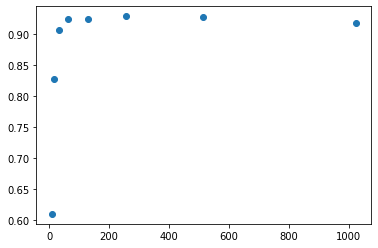

In [ ]:
plt.plot(num_neurons, table['mean'], marker='o')

In [ ]:
table = table.sort_values(by='mean', ascending=False)
table

,1st Fold,2nd Fold,3rd Fold,4th Fold,5th Fold,mean
256,0.929381,0.929381,0.919721,0.927574,0.935428,0.928297
512,0.926766,0.927637,0.935428,0.921466,0.926702,0.927600
128,0.917175,0.925894,0.931065,0.913613,0.931065,0.923762
64,0.920663,0.923278,0.930192,0.921466,0.923211,0.923762
1024,0.921534,0.909329,0.921466,0.921466,0.912740,0.917307
32,0.899738,0.908457,0.910122,0.910122,0.901396,0.905967
16,0.833479,0.819529,0.836824,0.798429,0.844677,0.826588
8,0.612031,0.616391,0.583770,0.605585,0.633508,0.610257


In [ ]:
table.to_csv('kfold_num_neurons_resuls.csv')

In [ ]:
best_num_neuron = 256

In [ ]:
# Rerunning to plot the graphs of accuracy and loss with model with best number of neurons in first dense layer
reg_model = create_model(best_num_neuron)

reg_model.compile(optimizer=tf.keras.optimizers.Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
history = reg_model.fit(train_ds, epochs = 50, validation_data=val_ds, callbacks=[es])

Epoch 1/50
180/180 [==============================] - 18s 56ms/step - loss: 2.3713 - accuracy: 0.4693 - val_loss: 0.8852 - val_accuracy: 0.7861
Epoch 2/50
180/180 [==============================] - 8s 45ms/step - loss: 0.7936 - accuracy: 0.7948 - val_loss: 0.5214 - val_accuracy: 0.8603
Epoch 3/50
180/180 [==============================] - 8s 45ms/step - loss: 0.5022 - accuracy: 0.8695 - val_loss: 0.3991 - val_accuracy: 0.8991
Epoch 4/50
180/180 [==============================] - 8s 44ms/step - loss: 0.3609 - accuracy: 0.9030 - val_loss: 0.3419 - val_accuracy: 0.9046
Epoch 5/50
180/180 [==============================] - 8s 45ms/step - loss: 0.2999 - accuracy: 0.9208 - val_loss: 0.2854 - val_accuracy: 0.9198
Epoch 6/50
180/180 [==============================] - 8s 45ms/step - loss: 0.2513 - accuracy: 0.9314 - val_loss: 0.2589 - val_accuracy: 0.9283
Epoch 7/50
180/180 [==============================] - 8s 44ms/step - loss: 0.2022 - accuracy: 0.9466 - val_loss: 0.2496 - val_accuracy: 0.927

Text(0, 0.5, 'Accuracy')

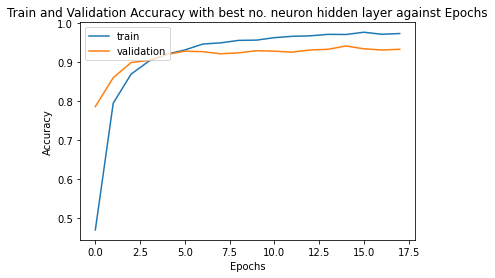

In [ ]:
# With additional dense layer accuracy plots
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title('Train and Validation Accuracy with best no. neuron hidden layer against Epochs')
plt.legend(['train', 'validation'], loc = 'upper left')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

Text(0, 0.5, 'Loss')

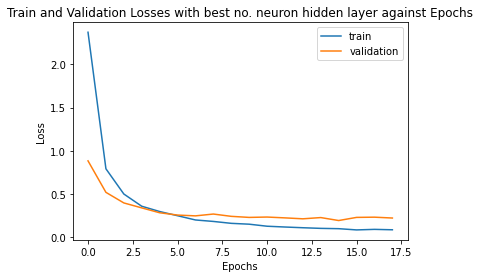

In [ ]:
# With addtional dense layer loss plots
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Train and Validation Losses with best no. neuron hidden layer against Epochs')
plt.legend(['train', 'validation'], loc = 'upper right')
plt.xlabel('Epochs')
plt.ylabel('Loss')

In [ ]:
# Adding a batch normalization and dropout layer after our hidden layer

# Creating a new model on top
inputs = tf.keras.layers.Input(shape=input_shape)

#  Float casting
x = tf.cast(inputs, tf.float32)

# Data Augmentation 
x = data_augmentation(x)

# Default Preprocess Function for our Pre-trained Models
x = preprocess_func(x)

# Creating our base model
base_model = model(weights="imagenet", 
                    include_top=False, 
                    input_shape=input_shape)
# Frezing the base_model weights
base_model.trainable = False
  
# Building the model
x = base_model(x, training = False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)

x = tf.keras.layers.Dense(best_num_neuron, activation='relu')(x)
x = BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.2)(x)

outputs = tf.keras.layers.Dense(102, activation='softmax')(x)
reg_model = tf.keras.Model(inputs, outputs)

reg_model.compile(optimizer=tf.keras.optimizers.Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
history = reg_model.fit(train_ds, epochs = 50, validation_data=val_ds, callbacks=[es])


Epoch 1/50
180/180 [==============================] - 19s 57ms/step - loss: 2.0016 - accuracy: 0.5530 - val_loss: 0.8885 - val_accuracy: 0.8414
Epoch 2/50
180/180 [==============================] - 8s 45ms/step - loss: 0.6574 - accuracy: 0.8428 - val_loss: 0.3991 - val_accuracy: 0.9028
Epoch 3/50
180/180 [==============================] - 8s 45ms/step - loss: 0.3940 - accuracy: 0.9088 - val_loss: 0.3278 - val_accuracy: 0.9137
Epoch 4/50
180/180 [==============================] - 8s 45ms/step - loss: 0.2618 - accuracy: 0.9341 - val_loss: 0.2635 - val_accuracy: 0.9289
Epoch 5/50
180/180 [==============================] - 8s 44ms/step - loss: 0.2108 - accuracy: 0.9463 - val_loss: 0.2721 - val_accuracy: 0.9222
Epoch 6/50
180/180 [==============================] - 8s 45ms/step - loss: 0.1671 - accuracy: 0.9607 - val_loss: 0.2218 - val_accuracy: 0.9356
Epoch 7/50
180/180 [==============================] - 8s 44ms/step - loss: 0.1500 - accuracy: 0.9611 - val_loss: 0.2405 - val_accuracy: 0.927

Text(0, 0.5, 'Accuracy')

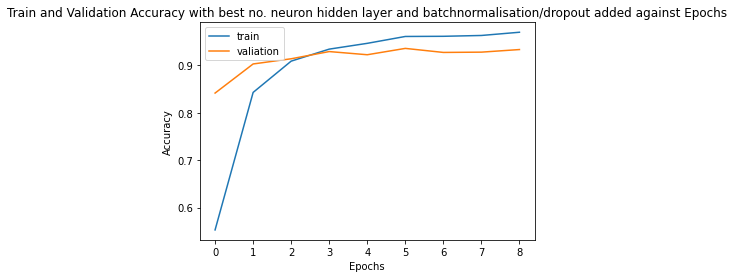

In [ ]:
# With additional dense and normalization layers accuracy plots
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title('Train and Validation Accuracy with best no. neuron hidden layer and batchnormalisation/dropout added against Epochs')
plt.legend(['train', 'valiation'], loc = 'upper left')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

Text(0, 0.5, 'Loss')

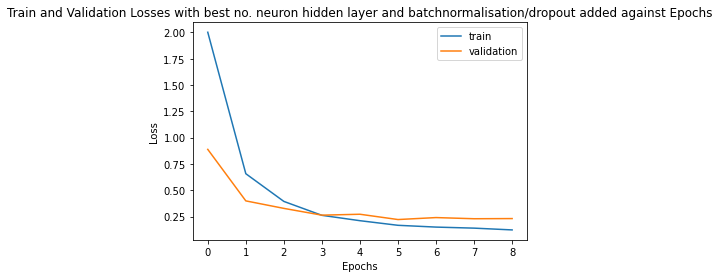

In [ ]:
# With additional dense and normalization layers loss plots
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Train and Validation Losses with best no. neuron hidden layer and batchnormalisation/dropout added against Epochs')
plt.legend(['train', 'validation'], loc = 'upper right')
plt.xlabel('Epochs')
plt.ylabel('Loss')

In [ ]:
# KFold CV to check best number of neurons in the first dense layer
learning_rates = [0.1, 0.05, 0.01, 0.005, 0.001, 0.0005, 0.0001]

kfold = KFold(n_splits = 5, shuffle=True, random_state=42)

mean_accuracy = []

input_shape=(224, 224, 3)

for learning_rate in tqdm(learning_rates):

  print('Running for Learning Rate :', learning_rate, ' -------------------------')
  cnt = 1
  accuracies = []
  for train_index, val_index in tqdm(kfold.split(X_train, Y_train)):

    x_train, y_train = X_train[train_index], Y_train[train_index]
    x_val, y_val = X_train[val_index], Y_train[val_index]

    train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
    val_ds = tf.data.Dataset.from_tensor_slices((x_val, y_val))

    # Batching and applying prefetching for faster processing
    train_ds = train_ds.cache().batch(32).prefetch(buffer_size = tf.data.experimental.AUTOTUNE)
    val_ds = val_ds.cache().batch(32).prefetch(buffer_size = tf.data.experimental.AUTOTUNE)
      
    # Creating a new model on top
    inputs = tf.keras.layers.Input(shape=input_shape)

    #  Float casting
    x = tf.cast(inputs, tf.float32)

    # Data Augmentation 
    x = data_augmentation(x)

    # Default Preprocess Function for our Pre-trained Models
    x = preprocess_func(x)

    # Creating our base model
    base_model = model(weights="imagenet", 
                        include_top=False, 
                        input_shape=input_shape)
    # Frezing the base_model weights
    base_model.trainable = False
      
    # Building the model
    x = base_model(x, training = False)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dropout(0.2)(x)

    outputs = tf.keras.layers.Dense(102, activation='softmax')(x)
    reg_model = tf.keras.Model(inputs, outputs)
    
    reg_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    history = reg_model.fit(train_ds, epochs = 50, validation_data=val_ds, callbacks=[es])

    accuracies.append(history.history['val_accuracy'][-1])
  
  mean_accuracy.append(accuracies)


  0%|          | 0/7 [00:00<?, ?it/s]

Running for Learning Rate : 0.1  -------------------------



0it [00:00, ?it/s]

Epoch 1/50
144/144 [==============================] - 17s 62ms/step - loss: 8.8763 - accuracy: 0.5952 - val_loss: 4.1751 - val_accuracy: 0.7559
Epoch 2/50
144/144 [==============================] - 6s 43ms/step - loss: 3.4355 - accuracy: 0.8020 - val_loss: 4.2047 - val_accuracy: 0.7942
Epoch 3/50
144/144 [==============================] - 6s 43ms/step - loss: 2.5089 - accuracy: 0.8565 - val_loss: 4.4115 - val_accuracy: 0.8003
Epoch 4/50
144/144 [==============================] - 6s 44ms/step - loss: 2.3543 - accuracy: 0.8726 - val_loss: 4.1819 - val_accuracy: 0.8213



1it [00:42, 42.26s/it]

Epoch 1/50
144/144 [==============================] - 22s 61ms/step - loss: 9.3797 - accuracy: 0.5821 - val_loss: 4.7625 - val_accuracy: 0.7332
Epoch 2/50
144/144 [==============================] - 6s 44ms/step - loss: 3.5921 - accuracy: 0.7952 - val_loss: 4.1171 - val_accuracy: 0.8038
Epoch 3/50
144/144 [==============================] - 6s 44ms/step - loss: 2.7617 - accuracy: 0.8576 - val_loss: 3.8840 - val_accuracy: 0.8221
Epoch 4/50
144/144 [==============================] - 6s 43ms/step - loss: 2.1175 - accuracy: 0.8848 - val_loss: 4.5976 - val_accuracy: 0.8213
Epoch 5/50
144/144 [==============================] - 6s 44ms/step - loss: 1.9478 - accuracy: 0.9003 - val_loss: 4.8502 - val_accuracy: 0.8483
Epoch 6/50
144/144 [==============================] - 6s 44ms/step - loss: 1.9407 - accuracy: 0.9019 - val_loss: 3.9089 - val_accuracy: 0.8675



2it [01:43, 53.22s/it]

Epoch 1/50
144/144 [==============================] - 17s 63ms/step - loss: 9.2041 - accuracy: 0.5765 - val_loss: 5.3509 - val_accuracy: 0.7435
Epoch 2/50
144/144 [==============================] - 6s 44ms/step - loss: 3.4416 - accuracy: 0.8009 - val_loss: 3.9106 - val_accuracy: 0.8106
Epoch 3/50
144/144 [==============================] - 6s 44ms/step - loss: 2.5737 - accuracy: 0.8513 - val_loss: 3.4272 - val_accuracy: 0.8490
Epoch 4/50
144/144 [==============================] - 6s 44ms/step - loss: 1.9370 - accuracy: 0.8897 - val_loss: 3.3511 - val_accuracy: 0.8630
Epoch 5/50
144/144 [==============================] - 6s 43ms/step - loss: 1.7224 - accuracy: 0.9069 - val_loss: 3.7862 - val_accuracy: 0.8534
Epoch 6/50
144/144 [==============================] - 6s 44ms/step - loss: 1.8870 - accuracy: 0.9030 - val_loss: 3.0063 - val_accuracy: 0.8831
Epoch 7/50
144/144 [==============================] - 6s 43ms/step - loss: 1.9322 - accuracy: 0.9065 - val_loss: 3.6663 - val_accuracy: 0.876


3it [02:57, 62.95s/it]

Epoch 1/50
144/144 [==============================] - 17s 62ms/step - loss: 8.9053 - accuracy: 0.5787 - val_loss: 4.5388 - val_accuracy: 0.7565
Epoch 2/50
144/144 [==============================] - 6s 44ms/step - loss: 3.4291 - accuracy: 0.7950 - val_loss: 3.5519 - val_accuracy: 0.8150
Epoch 3/50
144/144 [==============================] - 6s 43ms/step - loss: 2.5831 - accuracy: 0.8561 - val_loss: 4.7612 - val_accuracy: 0.8159
Epoch 4/50
144/144 [==============================] - 6s 44ms/step - loss: 2.2473 - accuracy: 0.8860 - val_loss: 3.0710 - val_accuracy: 0.8621
Epoch 5/50
144/144 [==============================] - 6s 43ms/step - loss: 2.0608 - accuracy: 0.9010 - val_loss: 4.2421 - val_accuracy: 0.8386
Epoch 6/50
144/144 [==============================] - 6s 43ms/step - loss: 1.6462 - accuracy: 0.9121 - val_loss: 4.5803 - val_accuracy: 0.8473
Epoch 7/50
144/144 [==============================] - 6s 44ms/step - loss: 1.5192 - accuracy: 0.9211 - val_loss: 4.4288 - val_accuracy: 0.862


4it [03:59, 62.45s/it]

Epoch 1/50
144/144 [==============================] - 17s 62ms/step - loss: 8.8577 - accuracy: 0.5887 - val_loss: 4.1948 - val_accuracy: 0.7714
Epoch 2/50
144/144 [==============================] - 6s 44ms/step - loss: 3.1339 - accuracy: 0.8107 - val_loss: 4.5471 - val_accuracy: 0.7941
Epoch 3/50
144/144 [==============================] - 6s 44ms/step - loss: 2.5862 - accuracy: 0.8576 - val_loss: 4.6074 - val_accuracy: 0.8045
Epoch 4/50
144/144 [==============================] - 6s 44ms/step - loss: 2.2300 - accuracy: 0.8799 - val_loss: 3.7699 - val_accuracy: 0.8525
Epoch 5/50
144/144 [==============================] - 6s 43ms/step - loss: 2.0171 - accuracy: 0.8953 - val_loss: 4.0622 - val_accuracy: 0.8578
Epoch 6/50
144/144 [==============================] - 6s 44ms/step - loss: 1.4993 - accuracy: 0.9187 - val_loss: 3.7333 - val_accuracy: 0.8831
Epoch 7/50
144/144 [==============================] - 6s 43ms/step - loss: 1.5351 - accuracy: 0.9195 - val_loss: 4.4302 - val_accuracy: 0.869


5it [05:13, 62.69s/it]
 14%|█▍        | 1/7 [05:13<31:20, 313.45s/it]

Running for Learning Rate : 0.05  -------------------------



0it [00:00, ?it/s]

Epoch 1/50
144/144 [==============================] - 17s 62ms/step - loss: 4.3451 - accuracy: 0.5978 - val_loss: 2.3291 - val_accuracy: 0.7620
Epoch 2/50
144/144 [==============================] - 6s 45ms/step - loss: 1.6830 - accuracy: 0.8157 - val_loss: 1.9374 - val_accuracy: 0.8047
Epoch 3/50
144/144 [==============================] - 6s 44ms/step - loss: 1.1221 - accuracy: 0.8683 - val_loss: 1.6298 - val_accuracy: 0.8561
Epoch 4/50
144/144 [==============================] - 6s 44ms/step - loss: 1.1040 - accuracy: 0.8846 - val_loss: 1.8991 - val_accuracy: 0.8344
Epoch 5/50
144/144 [==============================] - 6s 44ms/step - loss: 0.9998 - accuracy: 0.8920 - val_loss: 1.8076 - val_accuracy: 0.8570
Epoch 6/50
144/144 [==============================] - 6s 45ms/step - loss: 0.9794 - accuracy: 0.9053 - val_loss: 1.8331 - val_accuracy: 0.8718



1it [00:55, 55.48s/it]

Epoch 1/50
144/144 [==============================] - 17s 62ms/step - loss: 4.2913 - accuracy: 0.6061 - val_loss: 2.3429 - val_accuracy: 0.7323
Epoch 2/50
144/144 [==============================] - 6s 45ms/step - loss: 1.6014 - accuracy: 0.8159 - val_loss: 1.7942 - val_accuracy: 0.8265
Epoch 3/50
144/144 [==============================] - 6s 43ms/step - loss: 1.2835 - accuracy: 0.8595 - val_loss: 2.3779 - val_accuracy: 0.8108
Epoch 4/50
144/144 [==============================] - 6s 43ms/step - loss: 1.1962 - accuracy: 0.8774 - val_loss: 2.3012 - val_accuracy: 0.8309
Epoch 5/50
144/144 [==============================] - 6s 44ms/step - loss: 0.9120 - accuracy: 0.9012 - val_loss: 2.0781 - val_accuracy: 0.8439



2it [01:44, 51.56s/it]

Epoch 1/50
144/144 [==============================] - 17s 61ms/step - loss: 4.2963 - accuracy: 0.6053 - val_loss: 2.3698 - val_accuracy: 0.7731
Epoch 2/50
144/144 [==============================] - 7s 45ms/step - loss: 1.8509 - accuracy: 0.7970 - val_loss: 1.9426 - val_accuracy: 0.8115
Epoch 3/50
144/144 [==============================] - 6s 45ms/step - loss: 1.2130 - accuracy: 0.8685 - val_loss: 1.5139 - val_accuracy: 0.8490
Epoch 4/50
144/144 [==============================] - 6s 44ms/step - loss: 0.9872 - accuracy: 0.8903 - val_loss: 1.4118 - val_accuracy: 0.8735
Epoch 5/50
144/144 [==============================] - 6s 44ms/step - loss: 0.9101 - accuracy: 0.9051 - val_loss: 1.6255 - val_accuracy: 0.8656
Epoch 6/50
144/144 [==============================] - 6s 44ms/step - loss: 0.9804 - accuracy: 0.9010 - val_loss: 1.8744 - val_accuracy: 0.8630
Epoch 7/50
144/144 [==============================] - 6s 45ms/step - loss: 0.7719 - accuracy: 0.9250 - val_loss: 1.7003 - val_accuracy: 0.879


3it [02:46, 56.22s/it]

Epoch 1/50
144/144 [==============================] - 17s 61ms/step - loss: 4.3148 - accuracy: 0.5973 - val_loss: 1.9503 - val_accuracy: 0.7897
Epoch 2/50
144/144 [==============================] - 7s 46ms/step - loss: 1.5529 - accuracy: 0.8223 - val_loss: 1.8015 - val_accuracy: 0.8229
Epoch 3/50
144/144 [==============================] - 6s 44ms/step - loss: 1.1379 - accuracy: 0.8740 - val_loss: 1.9901 - val_accuracy: 0.8133
Epoch 4/50
144/144 [==============================] - 6s 43ms/step - loss: 1.1835 - accuracy: 0.8761 - val_loss: 2.7075 - val_accuracy: 0.8010
Epoch 5/50
144/144 [==============================] - 6s 45ms/step - loss: 0.9949 - accuracy: 0.8918 - val_loss: 1.8586 - val_accuracy: 0.8490



4it [03:35, 53.42s/it]

Epoch 1/50
144/144 [==============================] - 17s 61ms/step - loss: 4.0357 - accuracy: 0.6186 - val_loss: 2.6767 - val_accuracy: 0.7382
Epoch 2/50
144/144 [==============================] - 6s 45ms/step - loss: 1.6462 - accuracy: 0.8088 - val_loss: 1.9378 - val_accuracy: 0.8290
Epoch 3/50
144/144 [==============================] - 6s 44ms/step - loss: 1.2189 - accuracy: 0.8637 - val_loss: 2.0620 - val_accuracy: 0.8464
Epoch 4/50
144/144 [==============================] - 7s 46ms/step - loss: 1.0277 - accuracy: 0.8853 - val_loss: 1.8842 - val_accuracy: 0.8569
Epoch 5/50
144/144 [==============================] - 7s 46ms/step - loss: 0.6884 - accuracy: 0.9222 - val_loss: 1.8446 - val_accuracy: 0.8717
Epoch 6/50
144/144 [==============================] - 6s 44ms/step - loss: 0.8259 - accuracy: 0.9132 - val_loss: 2.0830 - val_accuracy: 0.8621
Epoch 7/50
144/144 [==============================] - 6s 44ms/step - loss: 0.9081 - accuracy: 0.9147 - val_loss: 1.8971 - val_accuracy: 0.886


5it [04:43, 56.73s/it]
 29%|██▊       | 2/7 [09:57<24:39, 295.92s/it]

Running for Learning Rate : 0.01  -------------------------



0it [00:00, ?it/s]

Epoch 1/50
144/144 [==============================] - 16s 61ms/step - loss: 1.4178 - accuracy: 0.6890 - val_loss: 0.4610 - val_accuracy: 0.8718
Epoch 2/50
144/144 [==============================] - 6s 44ms/step - loss: 0.3515 - accuracy: 0.9003 - val_loss: 0.4851 - val_accuracy: 0.8649
Epoch 3/50
144/144 [==============================] - 6s 44ms/step - loss: 0.2411 - accuracy: 0.9219 - val_loss: 0.4360 - val_accuracy: 0.8710
Epoch 4/50
144/144 [==============================] - 7s 45ms/step - loss: 0.1979 - accuracy: 0.9383 - val_loss: 0.4303 - val_accuracy: 0.8832
Epoch 5/50
144/144 [==============================] - 6s 44ms/step - loss: 0.1484 - accuracy: 0.9551 - val_loss: 0.3443 - val_accuracy: 0.9093
Epoch 6/50
144/144 [==============================] - 6s 43ms/step - loss: 0.1113 - accuracy: 0.9653 - val_loss: 0.3937 - val_accuracy: 0.8954
Epoch 7/50
144/144 [==============================] - 6s 44ms/step - loss: 0.1052 - accuracy: 0.9627 - val_loss: 0.3290 - val_accuracy: 0.918


1it [01:20, 80.40s/it]

Epoch 1/50
144/144 [==============================] - 23s 104ms/step - loss: 1.4058 - accuracy: 0.6907 - val_loss: 0.5603 - val_accuracy: 0.8352
Epoch 2/50
144/144 [==============================] - 6s 44ms/step - loss: 0.3393 - accuracy: 0.9049 - val_loss: 0.4204 - val_accuracy: 0.8771
Epoch 3/50
144/144 [==============================] - 6s 44ms/step - loss: 0.2125 - accuracy: 0.9348 - val_loss: 0.3456 - val_accuracy: 0.9093
Epoch 4/50
144/144 [==============================] - 6s 43ms/step - loss: 0.1671 - accuracy: 0.9461 - val_loss: 0.4324 - val_accuracy: 0.8849
Epoch 5/50
144/144 [==============================] - 6s 43ms/step - loss: 0.1322 - accuracy: 0.9590 - val_loss: 0.3691 - val_accuracy: 0.9032
Epoch 6/50
144/144 [==============================] - 6s 44ms/step - loss: 0.1281 - accuracy: 0.9629 - val_loss: 0.4251 - val_accuracy: 0.9111



2it [02:21, 68.99s/it]

Epoch 1/50
144/144 [==============================] - 17s 63ms/step - loss: 1.4593 - accuracy: 0.6755 - val_loss: 0.5899 - val_accuracy: 0.8176
Epoch 2/50
144/144 [==============================] - 6s 44ms/step - loss: 0.3489 - accuracy: 0.9030 - val_loss: 0.4020 - val_accuracy: 0.8822
Epoch 3/50
144/144 [==============================] - 6s 44ms/step - loss: 0.2089 - accuracy: 0.9381 - val_loss: 0.3947 - val_accuracy: 0.8822
Epoch 4/50
144/144 [==============================] - 6s 44ms/step - loss: 0.1806 - accuracy: 0.9468 - val_loss: 0.3673 - val_accuracy: 0.8979
Epoch 5/50
144/144 [==============================] - 6s 44ms/step - loss: 0.1180 - accuracy: 0.9605 - val_loss: 0.3031 - val_accuracy: 0.9171
Epoch 6/50
144/144 [==============================] - 6s 43ms/step - loss: 0.1150 - accuracy: 0.9627 - val_loss: 0.3093 - val_accuracy: 0.9223
Epoch 7/50
144/144 [==============================] - 6s 44ms/step - loss: 0.0986 - accuracy: 0.9695 - val_loss: 0.2946 - val_accuracy: 0.917


3it [03:48, 77.06s/it]

Epoch 1/50
144/144 [==============================] - 17s 62ms/step - loss: 1.4356 - accuracy: 0.6836 - val_loss: 0.5186 - val_accuracy: 0.8639
Epoch 2/50
144/144 [==============================] - 6s 44ms/step - loss: 0.3566 - accuracy: 0.9021 - val_loss: 0.4784 - val_accuracy: 0.8613
Epoch 3/50
144/144 [==============================] - 6s 44ms/step - loss: 0.2047 - accuracy: 0.9409 - val_loss: 0.4519 - val_accuracy: 0.8743
Epoch 4/50
144/144 [==============================] - 6s 44ms/step - loss: 0.1576 - accuracy: 0.9564 - val_loss: 0.4038 - val_accuracy: 0.8874
Epoch 5/50
144/144 [==============================] - 6s 44ms/step - loss: 0.1326 - accuracy: 0.9584 - val_loss: 0.3665 - val_accuracy: 0.8944
Epoch 6/50
144/144 [==============================] - 6s 43ms/step - loss: 0.1208 - accuracy: 0.9627 - val_loss: 0.3960 - val_accuracy: 0.8962
Epoch 7/50
144/144 [==============================] - 6s 43ms/step - loss: 0.0948 - accuracy: 0.9690 - val_loss: 0.3855 - val_accuracy: 0.897


4it [04:56, 73.56s/it]

Epoch 1/50
144/144 [==============================] - 17s 62ms/step - loss: 1.4558 - accuracy: 0.6753 - val_loss: 0.5346 - val_accuracy: 0.8543
Epoch 2/50
144/144 [==============================] - 6s 44ms/step - loss: 0.3113 - accuracy: 0.9123 - val_loss: 0.4317 - val_accuracy: 0.8831
Epoch 3/50
144/144 [==============================] - 6s 44ms/step - loss: 0.2033 - accuracy: 0.9409 - val_loss: 0.4242 - val_accuracy: 0.8901
Epoch 4/50
144/144 [==============================] - 6s 43ms/step - loss: 0.1823 - accuracy: 0.9433 - val_loss: 0.4482 - val_accuracy: 0.8918
Epoch 5/50
144/144 [==============================] - 6s 44ms/step - loss: 0.1290 - accuracy: 0.9621 - val_loss: 0.3768 - val_accuracy: 0.9075
Epoch 6/50
144/144 [==============================] - 6s 45ms/step - loss: 0.1043 - accuracy: 0.9658 - val_loss: 0.4119 - val_accuracy: 0.8944
Epoch 7/50
144/144 [==============================] - 6s 45ms/step - loss: 0.0978 - accuracy: 0.9710 - val_loss: 0.3691 - val_accuracy: 0.919


5it [06:17, 75.54s/it]
 43%|████▎     | 3/7 [16:14<22:13, 333.26s/it]

Running for Learning Rate : 0.005  -------------------------



0it [00:00, ?it/s]

Epoch 1/50
144/144 [==============================] - 17s 62ms/step - loss: 1.5472 - accuracy: 0.6672 - val_loss: 0.5444 - val_accuracy: 0.8666
Epoch 2/50
144/144 [==============================] - 6s 45ms/step - loss: 0.3746 - accuracy: 0.9106 - val_loss: 0.3976 - val_accuracy: 0.8936
Epoch 3/50
144/144 [==============================] - 6s 45ms/step - loss: 0.2267 - accuracy: 0.9470 - val_loss: 0.3454 - val_accuracy: 0.9085
Epoch 4/50
144/144 [==============================] - 6s 45ms/step - loss: 0.1536 - accuracy: 0.9684 - val_loss: 0.3018 - val_accuracy: 0.9172
Epoch 5/50
144/144 [==============================] - 6s 45ms/step - loss: 0.1104 - accuracy: 0.9797 - val_loss: 0.2892 - val_accuracy: 0.9198
Epoch 6/50
144/144 [==============================] - 6s 44ms/step - loss: 0.0942 - accuracy: 0.9802 - val_loss: 0.2892 - val_accuracy: 0.9233
Epoch 7/50
144/144 [==============================] - 6s 44ms/step - loss: 0.0799 - accuracy: 0.9817 - val_loss: 0.2832 - val_accuracy: 0.921


1it [01:31, 91.53s/it]

Epoch 1/50
144/144 [==============================] - 17s 62ms/step - loss: 1.5591 - accuracy: 0.6578 - val_loss: 0.5755 - val_accuracy: 0.8483
Epoch 2/50
144/144 [==============================] - 6s 45ms/step - loss: 0.3790 - accuracy: 0.9125 - val_loss: 0.3969 - val_accuracy: 0.8910
Epoch 3/50
144/144 [==============================] - 6s 44ms/step - loss: 0.2280 - accuracy: 0.9463 - val_loss: 0.3386 - val_accuracy: 0.8989
Epoch 4/50
144/144 [==============================] - 6s 45ms/step - loss: 0.1545 - accuracy: 0.9686 - val_loss: 0.3054 - val_accuracy: 0.9172
Epoch 5/50
144/144 [==============================] - 6s 45ms/step - loss: 0.1093 - accuracy: 0.9784 - val_loss: 0.2924 - val_accuracy: 0.9215
Epoch 6/50
144/144 [==============================] - 6s 44ms/step - loss: 0.0913 - accuracy: 0.9817 - val_loss: 0.2806 - val_accuracy: 0.9320
Epoch 7/50
144/144 [==============================] - 6s 44ms/step - loss: 0.0756 - accuracy: 0.9854 - val_loss: 0.2780 - val_accuracy: 0.925


2it [02:59, 89.24s/it]

Epoch 1/50
144/144 [==============================] - 17s 61ms/step - loss: 1.5753 - accuracy: 0.6635 - val_loss: 0.5696 - val_accuracy: 0.8499
Epoch 2/50
144/144 [==============================] - 6s 44ms/step - loss: 0.3896 - accuracy: 0.9089 - val_loss: 0.3833 - val_accuracy: 0.8883
Epoch 3/50
144/144 [==============================] - 6s 44ms/step - loss: 0.2215 - accuracy: 0.9520 - val_loss: 0.2975 - val_accuracy: 0.9075
Epoch 4/50
144/144 [==============================] - 6s 45ms/step - loss: 0.1526 - accuracy: 0.9673 - val_loss: 0.2702 - val_accuracy: 0.9258
Epoch 5/50
144/144 [==============================] - 6s 44ms/step - loss: 0.1144 - accuracy: 0.9758 - val_loss: 0.2686 - val_accuracy: 0.9188
Epoch 6/50
144/144 [==============================] - 6s 45ms/step - loss: 0.1022 - accuracy: 0.9780 - val_loss: 0.2603 - val_accuracy: 0.9250
Epoch 7/50
144/144 [==============================] - 6s 45ms/step - loss: 0.0791 - accuracy: 0.9836 - val_loss: 0.2240 - val_accuracy: 0.937


3it [04:32, 91.24s/it]

Epoch 1/50
144/144 [==============================] - 17s 61ms/step - loss: 1.5462 - accuracy: 0.6642 - val_loss: 0.6063 - val_accuracy: 0.8447
Epoch 2/50
144/144 [==============================] - 6s 45ms/step - loss: 0.3788 - accuracy: 0.9123 - val_loss: 0.4114 - val_accuracy: 0.8988
Epoch 3/50
144/144 [==============================] - 6s 44ms/step - loss: 0.2165 - accuracy: 0.9538 - val_loss: 0.3367 - val_accuracy: 0.9136
Epoch 4/50
144/144 [==============================] - 6s 45ms/step - loss: 0.1558 - accuracy: 0.9660 - val_loss: 0.3241 - val_accuracy: 0.9119
Epoch 5/50
144/144 [==============================] - 6s 45ms/step - loss: 0.1212 - accuracy: 0.9751 - val_loss: 0.3012 - val_accuracy: 0.9162
Epoch 6/50
144/144 [==============================] - 6s 43ms/step - loss: 0.0932 - accuracy: 0.9802 - val_loss: 0.3067 - val_accuracy: 0.9154
Epoch 7/50
144/144 [==============================] - 6s 44ms/step - loss: 0.0810 - accuracy: 0.9841 - val_loss: 0.2813 - val_accuracy: 0.923


4it [06:18, 97.12s/it]

Epoch 1/50
144/144 [==============================] - 17s 61ms/step - loss: 1.5533 - accuracy: 0.6611 - val_loss: 0.5650 - val_accuracy: 0.8621
Epoch 2/50
144/144 [==============================] - 6s 44ms/step - loss: 0.3637 - accuracy: 0.9182 - val_loss: 0.3954 - val_accuracy: 0.9014
Epoch 3/50
144/144 [==============================] - 6s 44ms/step - loss: 0.2143 - accuracy: 0.9522 - val_loss: 0.3443 - val_accuracy: 0.9127
Epoch 4/50
144/144 [==============================] - 6s 44ms/step - loss: 0.1575 - accuracy: 0.9640 - val_loss: 0.3267 - val_accuracy: 0.9197
Epoch 5/50
144/144 [==============================] - 6s 45ms/step - loss: 0.1074 - accuracy: 0.9791 - val_loss: 0.3022 - val_accuracy: 0.9197
Epoch 6/50
144/144 [==============================] - 6s 44ms/step - loss: 0.0890 - accuracy: 0.9815 - val_loss: 0.2919 - val_accuracy: 0.9284
Epoch 7/50
144/144 [==============================] - 6s 44ms/step - loss: 0.0802 - accuracy: 0.9823 - val_loss: 0.2871 - val_accuracy: 0.924


5it [08:17, 99.45s/it] 
 57%|█████▋    | 4/7 [24:32<19:54, 398.01s/it]

Running for Learning Rate : 0.001  -------------------------



0it [00:00, ?it/s]

Epoch 1/50
144/144 [==============================] - 17s 61ms/step - loss: 2.8955 - accuracy: 0.4212 - val_loss: 1.6460 - val_accuracy: 0.6914
Epoch 2/50
144/144 [==============================] - 6s 44ms/step - loss: 1.2275 - accuracy: 0.7989 - val_loss: 0.9643 - val_accuracy: 0.8352
Epoch 3/50
144/144 [==============================] - 6s 45ms/step - loss: 0.7686 - accuracy: 0.8805 - val_loss: 0.7157 - val_accuracy: 0.8727
Epoch 4/50
144/144 [==============================] - 7s 45ms/step - loss: 0.5532 - accuracy: 0.9173 - val_loss: 0.5850 - val_accuracy: 0.8936
Epoch 5/50
144/144 [==============================] - 6s 44ms/step - loss: 0.4435 - accuracy: 0.9341 - val_loss: 0.5053 - val_accuracy: 0.9024
Epoch 6/50
144/144 [==============================] - 6s 45ms/step - loss: 0.3590 - accuracy: 0.9492 - val_loss: 0.4523 - val_accuracy: 0.9119
Epoch 7/50
144/144 [==============================] - 6s 44ms/step - loss: 0.3000 - accuracy: 0.9564 - val_loss: 0.4112 - val_accuracy: 0.912


1it [03:27, 207.46s/it]

Epoch 1/50
144/144 [==============================] - 16s 60ms/step - loss: 2.9031 - accuracy: 0.4266 - val_loss: 1.6195 - val_accuracy: 0.7193
Epoch 2/50
144/144 [==============================] - 6s 44ms/step - loss: 1.2337 - accuracy: 0.8015 - val_loss: 0.9498 - val_accuracy: 0.8378
Epoch 3/50
144/144 [==============================] - 6s 44ms/step - loss: 0.7650 - accuracy: 0.8833 - val_loss: 0.6974 - val_accuracy: 0.8832
Epoch 4/50
144/144 [==============================] - 6s 45ms/step - loss: 0.5512 - accuracy: 0.9178 - val_loss: 0.5648 - val_accuracy: 0.8971
Epoch 5/50
144/144 [==============================] - 6s 44ms/step - loss: 0.4313 - accuracy: 0.9389 - val_loss: 0.4882 - val_accuracy: 0.9024
Epoch 6/50
144/144 [==============================] - 6s 44ms/step - loss: 0.3533 - accuracy: 0.9527 - val_loss: 0.4306 - val_accuracy: 0.9111
Epoch 7/50
144/144 [==============================] - 6s 44ms/step - loss: 0.3032 - accuracy: 0.9575 - val_loss: 0.3932 - val_accuracy: 0.919


2it [07:25, 225.47s/it]

Epoch 1/50
144/144 [==============================] - 17s 61ms/step - loss: 2.8938 - accuracy: 0.4309 - val_loss: 1.6309 - val_accuracy: 0.7007
Epoch 2/50
144/144 [==============================] - 6s 45ms/step - loss: 1.2372 - accuracy: 0.8005 - val_loss: 0.9507 - val_accuracy: 0.8185
Epoch 3/50
144/144 [==============================] - 6s 44ms/step - loss: 0.7714 - accuracy: 0.8846 - val_loss: 0.6895 - val_accuracy: 0.8726
Epoch 4/50
144/144 [==============================] - 6s 45ms/step - loss: 0.5668 - accuracy: 0.9184 - val_loss: 0.5583 - val_accuracy: 0.8944
Epoch 5/50
144/144 [==============================] - 7s 46ms/step - loss: 0.4395 - accuracy: 0.9322 - val_loss: 0.4710 - val_accuracy: 0.9040
Epoch 6/50
144/144 [==============================] - 6s 44ms/step - loss: 0.3677 - accuracy: 0.9459 - val_loss: 0.4192 - val_accuracy: 0.9162
Epoch 7/50
144/144 [==============================] - 6s 45ms/step - loss: 0.3030 - accuracy: 0.9568 - val_loss: 0.3800 - val_accuracy: 0.917


3it [12:20, 257.18s/it]

Epoch 1/50
144/144 [==============================] - 25s 65ms/step - loss: 2.8638 - accuracy: 0.4370 - val_loss: 1.6133 - val_accuracy: 0.7147
Epoch 2/50
144/144 [==============================] - 7s 46ms/step - loss: 1.2107 - accuracy: 0.8029 - val_loss: 0.9715 - val_accuracy: 0.8255
Epoch 3/50
144/144 [==============================] - 7s 47ms/step - loss: 0.7686 - accuracy: 0.8820 - val_loss: 0.7273 - val_accuracy: 0.8586
Epoch 4/50
144/144 [==============================] - 7s 46ms/step - loss: 0.5550 - accuracy: 0.9156 - val_loss: 0.5949 - val_accuracy: 0.8822
Epoch 5/50
144/144 [==============================] - 7s 46ms/step - loss: 0.4359 - accuracy: 0.9370 - val_loss: 0.5139 - val_accuracy: 0.8997
Epoch 6/50
144/144 [==============================] - 7s 46ms/step - loss: 0.3531 - accuracy: 0.9494 - val_loss: 0.4652 - val_accuracy: 0.9066
Epoch 7/50
144/144 [==============================] - 7s 46ms/step - loss: 0.3007 - accuracy: 0.9560 - val_loss: 0.4231 - val_accuracy: 0.913


4it [16:23, 251.59s/it]

Epoch 1/50
144/144 [==============================] - 17s 64ms/step - loss: 2.8528 - accuracy: 0.4344 - val_loss: 1.6298 - val_accuracy: 0.7286
Epoch 2/50
144/144 [==============================] - 7s 46ms/step - loss: 1.2086 - accuracy: 0.8031 - val_loss: 0.9622 - val_accuracy: 0.8403
Epoch 3/50
144/144 [==============================] - 7s 46ms/step - loss: 0.7487 - accuracy: 0.8860 - val_loss: 0.7098 - val_accuracy: 0.8735
Epoch 4/50
144/144 [==============================] - 7s 46ms/step - loss: 0.5432 - accuracy: 0.9224 - val_loss: 0.5802 - val_accuracy: 0.8935
Epoch 5/50
144/144 [==============================] - 7s 47ms/step - loss: 0.4268 - accuracy: 0.9407 - val_loss: 0.5047 - val_accuracy: 0.9005
Epoch 6/50
144/144 [==============================] - 7s 46ms/step - loss: 0.3544 - accuracy: 0.9481 - val_loss: 0.4525 - val_accuracy: 0.9092
Epoch 7/50
144/144 [==============================] - 7s 46ms/step - loss: 0.2925 - accuracy: 0.9590 - val_loss: 0.4126 - val_accuracy: 0.911


5it [20:36, 247.30s/it]
 71%|███████▏  | 5/7 [45:08<23:20, 700.39s/it]

Running for Learning Rate : 0.0005  -------------------------



0it [00:00, ?it/s]

Epoch 1/50
144/144 [==============================] - 17s 64ms/step - loss: 3.5451 - accuracy: 0.2824 - val_loss: 2.5211 - val_accuracy: 0.5440
Epoch 2/50
144/144 [==============================] - 7s 46ms/step - loss: 2.0368 - accuracy: 0.6467 - val_loss: 1.6182 - val_accuracy: 0.7289
Epoch 3/50
144/144 [==============================] - 7s 46ms/step - loss: 1.3689 - accuracy: 0.7945 - val_loss: 1.1917 - val_accuracy: 0.8065
Epoch 4/50
144/144 [==============================] - 7s 46ms/step - loss: 1.0191 - accuracy: 0.8561 - val_loss: 0.9538 - val_accuracy: 0.8361
Epoch 5/50
144/144 [==============================] - 7s 46ms/step - loss: 0.8100 - accuracy: 0.8912 - val_loss: 0.8045 - val_accuracy: 0.8640
Epoch 6/50
144/144 [==============================] - 7s 46ms/step - loss: 0.6713 - accuracy: 0.9075 - val_loss: 0.7024 - val_accuracy: 0.8753
Epoch 7/50
144/144 [==============================] - 7s 46ms/step - loss: 0.5715 - accuracy: 0.9272 - val_loss: 0.6288 - val_accuracy: 0.886


1it [05:45, 345.63s/it]

Epoch 1/50
144/144 [==============================] - 18s 65ms/step - loss: 3.5829 - accuracy: 0.2752 - val_loss: 2.5376 - val_accuracy: 0.5371
Epoch 2/50
144/144 [==============================] - 7s 46ms/step - loss: 2.0458 - accuracy: 0.6467 - val_loss: 1.6177 - val_accuracy: 0.7228
Epoch 3/50
144/144 [==============================] - 7s 46ms/step - loss: 1.3757 - accuracy: 0.7900 - val_loss: 1.1857 - val_accuracy: 0.8047
Epoch 4/50
144/144 [==============================] - 7s 46ms/step - loss: 1.0212 - accuracy: 0.8567 - val_loss: 0.9444 - val_accuracy: 0.8448
Epoch 5/50
144/144 [==============================] - 7s 46ms/step - loss: 0.8118 - accuracy: 0.8859 - val_loss: 0.7917 - val_accuracy: 0.8701
Epoch 6/50
144/144 [==============================] - 7s 46ms/step - loss: 0.6714 - accuracy: 0.9069 - val_loss: 0.6908 - val_accuracy: 0.8875
Epoch 7/50
144/144 [==============================] - 7s 46ms/step - loss: 0.5684 - accuracy: 0.9219 - val_loss: 0.6098 - val_accuracy: 0.898


2it [11:32, 346.34s/it]

Epoch 1/50
144/144 [==============================] - 17s 63ms/step - loss: 3.5080 - accuracy: 0.2843 - val_loss: 2.5361 - val_accuracy: 0.5271
Epoch 2/50
144/144 [==============================] - 7s 45ms/step - loss: 2.0264 - accuracy: 0.6430 - val_loss: 1.6141 - val_accuracy: 0.7339
Epoch 3/50
144/144 [==============================] - 7s 45ms/step - loss: 1.3642 - accuracy: 0.7931 - val_loss: 1.1772 - val_accuracy: 0.8063
Epoch 4/50
144/144 [==============================] - 7s 45ms/step - loss: 1.0186 - accuracy: 0.8598 - val_loss: 0.9357 - val_accuracy: 0.8429
Epoch 5/50
144/144 [==============================] - 7s 46ms/step - loss: 0.8098 - accuracy: 0.8825 - val_loss: 0.7788 - val_accuracy: 0.8647
Epoch 6/50
144/144 [==============================] - 7s 46ms/step - loss: 0.6780 - accuracy: 0.9054 - val_loss: 0.6766 - val_accuracy: 0.8726
Epoch 7/50
144/144 [==============================] - 7s 46ms/step - loss: 0.5845 - accuracy: 0.9132 - val_loss: 0.5996 - val_accuracy: 0.886


3it [17:17, 345.53s/it]

Epoch 1/50
144/144 [==============================] - 17s 63ms/step - loss: 3.5388 - accuracy: 0.2852 - val_loss: 2.5245 - val_accuracy: 0.5105
Epoch 2/50
144/144 [==============================] - 7s 46ms/step - loss: 2.0425 - accuracy: 0.6424 - val_loss: 1.6279 - val_accuracy: 0.7094
Epoch 3/50
144/144 [==============================] - 7s 46ms/step - loss: 1.3695 - accuracy: 0.7889 - val_loss: 1.2042 - val_accuracy: 0.7941
Epoch 4/50
144/144 [==============================] - 7s 45ms/step - loss: 1.0240 - accuracy: 0.8498 - val_loss: 0.9663 - val_accuracy: 0.8412
Epoch 5/50
144/144 [==============================] - 7s 45ms/step - loss: 0.8130 - accuracy: 0.8831 - val_loss: 0.8159 - val_accuracy: 0.8569
Epoch 6/50
144/144 [==============================] - 7s 45ms/step - loss: 0.6733 - accuracy: 0.9067 - val_loss: 0.7124 - val_accuracy: 0.8735
Epoch 7/50
144/144 [==============================] - 7s 46ms/step - loss: 0.5699 - accuracy: 0.9228 - val_loss: 0.6376 - val_accuracy: 0.881


4it [23:02, 345.33s/it]

Epoch 1/50
144/144 [==============================] - 17s 63ms/step - loss: 3.5221 - accuracy: 0.2891 - val_loss: 2.5246 - val_accuracy: 0.5401
Epoch 2/50
144/144 [==============================] - 7s 45ms/step - loss: 2.0212 - accuracy: 0.6452 - val_loss: 1.6219 - val_accuracy: 0.7435
Epoch 3/50
144/144 [==============================] - 7s 45ms/step - loss: 1.3515 - accuracy: 0.7946 - val_loss: 1.1946 - val_accuracy: 0.8229
Epoch 4/50
144/144 [==============================] - 7s 45ms/step - loss: 1.0087 - accuracy: 0.8585 - val_loss: 0.9537 - val_accuracy: 0.8586
Epoch 5/50
144/144 [==============================] - 7s 45ms/step - loss: 0.8044 - accuracy: 0.8875 - val_loss: 0.8078 - val_accuracy: 0.8717
Epoch 6/50
144/144 [==============================] - 7s 45ms/step - loss: 0.6624 - accuracy: 0.9139 - val_loss: 0.7013 - val_accuracy: 0.8901
Epoch 7/50
144/144 [==============================] - 7s 45ms/step - loss: 0.5565 - accuracy: 0.9289 - val_loss: 0.6293 - val_accuracy: 0.893


5it [28:46, 345.27s/it]
 86%|████████▌ | 6/7 [1:13:54<17:29, 1049.23s/it]

Running for Learning Rate : 0.0001  -------------------------



0it [00:00, ?it/s]

Epoch 1/50
144/144 [==============================] - 17s 62ms/step - loss: 4.3756 - accuracy: 0.0731 - val_loss: 4.0176 - val_accuracy: 0.1866
Epoch 2/50
144/144 [==============================] - 6s 45ms/step - loss: 3.8045 - accuracy: 0.2159 - val_loss: 3.5423 - val_accuracy: 0.2903
Epoch 3/50
144/144 [==============================] - 7s 45ms/step - loss: 3.3661 - accuracy: 0.3306 - val_loss: 3.1479 - val_accuracy: 0.3836
Epoch 4/50
144/144 [==============================] - 7s 45ms/step - loss: 2.9855 - accuracy: 0.4288 - val_loss: 2.8124 - val_accuracy: 0.4865
Epoch 5/50
144/144 [==============================] - 6s 45ms/step - loss: 2.6711 - accuracy: 0.5132 - val_loss: 2.5264 - val_accuracy: 0.5527
Epoch 6/50
144/144 [==============================] - 6s 45ms/step - loss: 2.4052 - accuracy: 0.5802 - val_loss: 2.2834 - val_accuracy: 0.5929
Epoch 7/50
144/144 [==============================] - 6s 45ms/step - loss: 2.1658 - accuracy: 0.6410 - val_loss: 2.0770 - val_accuracy: 0.634


1it [05:41, 341.67s/it]

Epoch 1/50
144/144 [==============================] - 17s 62ms/step - loss: 4.4303 - accuracy: 0.0521 - val_loss: 4.0930 - val_accuracy: 0.1107
Epoch 2/50
144/144 [==============================] - 6s 45ms/step - loss: 3.8530 - accuracy: 0.1760 - val_loss: 3.6023 - val_accuracy: 0.2511
Epoch 3/50
144/144 [==============================] - 6s 45ms/step - loss: 3.3957 - accuracy: 0.3215 - val_loss: 3.1884 - val_accuracy: 0.3731
Epoch 4/50
144/144 [==============================] - 6s 45ms/step - loss: 3.0141 - accuracy: 0.4314 - val_loss: 2.8361 - val_accuracy: 0.4664
Epoch 5/50
144/144 [==============================] - 6s 45ms/step - loss: 2.6863 - accuracy: 0.5101 - val_loss: 2.5379 - val_accuracy: 0.5379
Epoch 6/50
144/144 [==============================] - 6s 45ms/step - loss: 2.4071 - accuracy: 0.5865 - val_loss: 2.2856 - val_accuracy: 0.6103
Epoch 7/50
144/144 [==============================] - 6s 45ms/step - loss: 2.1678 - accuracy: 0.6471 - val_loss: 2.0731 - val_accuracy: 0.667


2it [11:23, 341.68s/it]

Epoch 1/50
144/144 [==============================] - 17s 62ms/step - loss: 4.4121 - accuracy: 0.0693 - val_loss: 4.0797 - val_accuracy: 0.1361
Epoch 2/50
144/144 [==============================] - 6s 45ms/step - loss: 3.8383 - accuracy: 0.1945 - val_loss: 3.6060 - val_accuracy: 0.2661
Epoch 3/50
144/144 [==============================] - 6s 45ms/step - loss: 3.3855 - accuracy: 0.3057 - val_loss: 3.2036 - val_accuracy: 0.3909
Epoch 4/50
144/144 [==============================] - 6s 45ms/step - loss: 3.0028 - accuracy: 0.4126 - val_loss: 2.8568 - val_accuracy: 0.4808
Epoch 5/50
144/144 [==============================] - 6s 45ms/step - loss: 2.6830 - accuracy: 0.5039 - val_loss: 2.5597 - val_accuracy: 0.5602
Epoch 6/50
144/144 [==============================] - 6s 45ms/step - loss: 2.4001 - accuracy: 0.5824 - val_loss: 2.3057 - val_accuracy: 0.6126
Epoch 7/50
144/144 [==============================] - 6s 45ms/step - loss: 2.1748 - accuracy: 0.6385 - val_loss: 2.0900 - val_accuracy: 0.649


3it [17:05, 341.75s/it]

Epoch 1/50
144/144 [==============================] - 17s 62ms/step - loss: 4.4141 - accuracy: 0.0608 - val_loss: 4.0606 - val_accuracy: 0.1614
Epoch 2/50
144/144 [==============================] - 6s 45ms/step - loss: 3.8385 - accuracy: 0.2124 - val_loss: 3.5746 - val_accuracy: 0.3072
Epoch 3/50
144/144 [==============================] - 6s 45ms/step - loss: 3.3902 - accuracy: 0.3474 - val_loss: 3.1656 - val_accuracy: 0.4276
Epoch 4/50
144/144 [==============================] - 6s 45ms/step - loss: 3.0116 - accuracy: 0.4494 - val_loss: 2.8191 - val_accuracy: 0.4895
Epoch 5/50
144/144 [==============================] - 6s 45ms/step - loss: 2.6712 - accuracy: 0.5388 - val_loss: 2.5257 - val_accuracy: 0.5506
Epoch 6/50
144/144 [==============================] - 6s 45ms/step - loss: 2.4075 - accuracy: 0.5877 - val_loss: 2.2802 - val_accuracy: 0.5916
Epoch 7/50
144/144 [==============================] - 6s 45ms/step - loss: 2.1620 - accuracy: 0.6502 - val_loss: 2.0745 - val_accuracy: 0.623


4it [22:50, 343.04s/it]

Epoch 1/50
144/144 [==============================] - 17s 63ms/step - loss: 4.4050 - accuracy: 0.0628 - val_loss: 4.0347 - val_accuracy: 0.1623
Epoch 2/50
144/144 [==============================] - 6s 45ms/step - loss: 3.8244 - accuracy: 0.2163 - val_loss: 3.5518 - val_accuracy: 0.3141
Epoch 3/50
144/144 [==============================] - 7s 45ms/step - loss: 3.3738 - accuracy: 0.3373 - val_loss: 3.1527 - val_accuracy: 0.4075
Epoch 4/50
144/144 [==============================] - 7s 45ms/step - loss: 2.9935 - accuracy: 0.4352 - val_loss: 2.8143 - val_accuracy: 0.4965
Epoch 5/50
144/144 [==============================] - 7s 45ms/step - loss: 2.6600 - accuracy: 0.5153 - val_loss: 2.5271 - val_accuracy: 0.5611
Epoch 6/50
144/144 [==============================] - 6s 45ms/step - loss: 2.3877 - accuracy: 0.5929 - val_loss: 2.2826 - val_accuracy: 0.6091
Epoch 7/50
144/144 [==============================] - 6s 45ms/step - loss: 2.1498 - accuracy: 0.6428 - val_loss: 2.0756 - val_accuracy: 0.658


5it [28:31, 342.34s/it]
100%|██████████| 7/7 [1:42:26<00:00, 878.10s/it] 


In [ ]:
table = pd.DataFrame(mean_accuracy, learning_rates)
table.columns =['1st Fold', '2nd Fold', '3rd Fold', '4th Fold', '5th Fold']
table['mean'] = table.mean(axis=1)

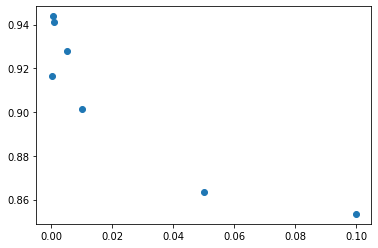

In [ ]:
plt.scatter(learning_rates, table['mean'])

In [ ]:
table = table.sort_values(by='mean', ascending=False)
table

,1st Fold,2nd Fold,3rd Fold,4th Fold,5th Fold,mean
0.0005,0.942459,0.947690,0.952007,0.937173,0.939791,0.943824
0.0010,0.936356,0.942459,0.949389,0.939791,0.937173,0.941033
0.0050,0.922406,0.933740,0.924956,0.926702,0.932810,0.928123
0.0001,0.911944,0.921534,0.919721,0.915358,0.913613,0.916434
0.0100,0.891020,0.911072,0.914485,0.890925,0.898778,0.901256
0.0500,0.871840,0.843941,0.879581,0.849040,0.873473,0.863575
0.1000,0.821273,0.867480,0.865620,0.862129,0.850785,0.853457


In [ ]:
table.to_csv('kfold_learning_rate_resuls.csv')

In [ ]:
best_learning_rate = 0.001

In [ ]:
# Fetching all pretrained keras models
all_models_dictionary = {m[0]:m[1] for m in inspect.getmembers(tf.keras.applications, inspect.isfunction)}

# List of all pretrained Keras Model
all_models_dictionary

{'DenseNet121': <function keras.applications.densenet.DenseNet121(include_top=True, weights='imagenet', input_tensor=None, input_shape=None, pooling=None, classes=1000, classifier_activation='softmax')>,
 'DenseNet169': <function keras.applications.densenet.DenseNet169(include_top=True, weights='imagenet', input_tensor=None, input_shape=None, pooling=None, classes=1000, classifier_activation='softmax')>,
 'DenseNet201': <function keras.applications.densenet.DenseNet201(include_top=True, weights='imagenet', input_tensor=None, input_shape=None, pooling=None, classes=1000, classifier_activation='softmax')>,
 'EfficientNetB0': <function keras.applications.efficientnet.EfficientNetB0(include_top=True, weights='imagenet', input_tensor=None, input_shape=None, pooling=None, classes=1000, classifier_activation='softmax', **kwargs)>,
 'EfficientNetB1': <function keras.applications.efficientnet.EfficientNetB1(include_top=True, weights='imagenet', input_tensor=None, input_shape=None, pooling=None,

In [ ]:
# List of all pretrained Keras models specifically for image classification
image_pretrained_models = [
        'VGG16',
        'VGG19',
        'ResNet50',
        'ResNet50V2',
        'ResNet101',
        'ResNet101V2',
        'ResNet152',
        'ResNet152V2',
        'MobileNet',
        'MobileNetV2',
        'DenseNet121',
        'DenseNet169',
        'DenseNet201',
        'NASNetMobile',
        'EfficientNetB0',
        'EfficientNetB1',
        'EfficientNetB2',
        'EfficientNetB3',
        'EfficientNetB4',
        'EfficientNetB5',
        'EfficientNetB6',
        'EfficientNetB7',
        'EfficientNetV2B0',
        'EfficientNetV2B1',
        'EfficientNetV2B2',
        'EfficientNetV2B3',
        'EfficientNetV2S',
        'EfficientNetV2M',
        'EfficientNetV2L',
        'Xception',
        'InceptionV3',
        'InceptionResNetV2',
        'NASNetLarge'
    ]

In [ ]:
preprocess_func = { 'VGG16' : tf.keras.applications.vgg16.preprocess_input,
                    'VGG19':tf.keras.applications.vgg19.preprocess_input,
                    'ResNet50':tf.keras.applications.resnet.preprocess_input,
                    'ResNet50V2':tf.keras.applications.resnet_v2.preprocess_input,
                    'ResNet101':tf.keras.applications.resnet.preprocess_input,
                    'ResNet101V2':tf.keras.applications.resnet_v2.preprocess_input,
                    'ResNet152':tf.keras.applications.resnet.preprocess_input,
                    'ResNet152V2':tf.keras.applications.resnet_v2.preprocess_input,
                    'MobileNet':tf.keras.applications.mobilenet.preprocess_input,
                    'MobileNetV2':tf.keras.applications.mobilenet_v2.preprocess_input,
                    'DenseNet121':tf.keras.applications.densenet.preprocess_input,
                    'DenseNet169':tf.keras.applications.densenet.preprocess_input,
                    'DenseNet201':tf.keras.applications.densenet.preprocess_input,
                    'NASNetMobile':tf.keras.applications.nasnet.preprocess_input,
                    'EfficientNetB0':tf.keras.applications.efficientnet.preprocess_input,
                    'EfficientNetB1':tf.keras.applications.efficientnet.preprocess_input,
                    'EfficientNetB2':tf.keras.applications.efficientnet.preprocess_input,
                    'EfficientNetB3':tf.keras.applications.efficientnet.preprocess_input,
                    'EfficientNetB4':tf.keras.applications.efficientnet.preprocess_input,
                    'EfficientNetB5':tf.keras.applications.efficientnet.preprocess_input,
                    'EfficientNetB6':tf.keras.applications.efficientnet.preprocess_input,
                    'EfficientNetB7':tf.keras.applications.efficientnet.preprocess_input,
                    'EfficientNetV2B0':tf.keras.applications.efficientnet_v2.preprocess_input,
                    'EfficientNetV2B1':tf.keras.applications.efficientnet_v2.preprocess_input,
                    'EfficientNetV2B2':tf.keras.applications.efficientnet_v2.preprocess_input,
                    'EfficientNetV2B3':tf.keras.applications.efficientnet_v2.preprocess_input,
                    'EfficientNetV2S':tf.keras.applications.efficientnet_v2.preprocess_input,
                    'EfficientNetV2M':tf.keras.applications.efficientnet_v2.preprocess_input,
                    'EfficientNetV2L':tf.keras.applications.efficientnet_v2.preprocess_input,
                    'Xception': tf.keras.applications.xception.preprocess_input,
                    'InceptionV3':tf.keras.applications.inception_v3.preprocess_input,
                    'InceptionResNetV2':tf.keras.applications.inception_resnet_v2.preprocess_input,
                    'NASNetLarge':tf.keras.applications.nasnet.preprocess_input
                  }

In [ ]:
# Fetching only the models specifically mentioned for image classification
image_models = {image_pretrained_model: all_models_dictionary[image_pretrained_model] for image_pretrained_model in image_pretrained_models}

# Corresponds to Keras documentation for image specific pretrained models
len(image_models)

33

In [ ]:
top_5_models = []
pre_trained = pd.read_csv('/content/drive/My Drive/NNDL Project Submission/transfer_learning_model_results_pure.csv')
for i in tqdm(range(5)):
  top_5_models.append(pre_trained['pretrained_model_name'][i])

100%|██████████| 5/5 [00:00<00:00, 9637.65it/s]


In [ ]:
top_5_models

['EfficientNetV2B2',
 'EfficientNetB2',
 'EfficientNetB1',
 'EfficientNetV2B1',
 'DenseNet201']

In [ ]:
for model in top_5_models:
  # Creating a new model on top
  inputs = tf.keras.layers.Input(shape=input_shape)
  
  #  Float casting
  x = tf.cast(inputs, tf.float32)

  # Data Augmentation 
  x = data_augmentation(x)

  # Default Preprocess Function for our Pre-trained Models
  x = preprocess_func[model](x)
  
  # Creating our base model
  base_model = image_models[model](weights="imagenet", 
                      include_top=False, 
                      input_shape=input_shape)
  # Frezing the base_model weights
  base_model.trainable = False
    
  # Building the model
  x = base_model(x, training = False)
  x = tf.keras.layers.GlobalAveragePooling2D()(x)
  x = tf.keras.layers.Dropout(0.2)(x)

  outputs = tf.keras.layers.Dense(102, activation='softmax')(x)
  reg_model = tf.keras.Model(inputs, outputs)

  reg_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = best_learning_rate), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
  history = reg_model.fit(train_ds, epochs = 50, validation_data=val_ds, callbacks=[es])

  # Saving our models for fine-tuning later in 'Fine Tuning.ipynb'
  reg_model.save('/content/drive/My Drive/NNDL Project Submission/trained_models/'+model)
  reg_model.save(model)

  plt.plot(history.history["accuracy"])
  plt.plot(history.history["val_accuracy"])
  plt.title('Train and Validation Accuracy with best learning rate against Epochs')
  plt.legend(['train', 'validation'], loc = 'upper left')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.savefig(model+'_accuracy.png')

  plt.clf()

  plt.plot(history.history["loss"])
  plt.plot(history.history["val_loss"])
  plt.title('Train and Validation Accuracy with best learning rate against Epochs')
  plt.legend(['train', 'validation'], loc = 'upper left')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.savefig(model+'_loss.png')

  plt.clf()

Epoch 1/50
180/180 [==============================] - 19s 60ms/step - loss: 2.6012 - accuracy: 0.4923 - val_loss: 1.3062 - val_accuracy: 0.7807
Epoch 2/50
180/180 [==============================] - 8s 46ms/step - loss: 1.0138 - accuracy: 0.8405 - val_loss: 0.7543 - val_accuracy: 0.8748
Epoch 3/50
180/180 [==============================] - 8s 46ms/step - loss: 0.6421 - accuracy: 0.9006 - val_loss: 0.5539 - val_accuracy: 0.9010
Epoch 4/50
180/180 [==============================] - 8s 46ms/step - loss: 0.4633 - accuracy: 0.9293 - val_loss: 0.4535 - val_accuracy: 0.9143
Epoch 5/50
180/180 [==============================] - 8s 45ms/step - loss: 0.3691 - accuracy: 0.9424 - val_loss: 0.3960 - val_accuracy: 0.9241
Epoch 6/50
180/180 [==============================] - 8s 45ms/step - loss: 0.3035 - accuracy: 0.9548 - val_loss: 0.3508 - val_accuracy: 0.9259
Epoch 7/50
180/180 [==============================] - 8s 45ms/step - loss: 0.2557 - accuracy: 0.9618 - val_loss: 0.3226 - val_accuracy: 0.930

31790344/31790344 [==============================] - 2s 0us/step
Epoch 1/50
180/180 [==============================] - 19s 63ms/step - loss: 2.5766 - accuracy: 0.4993 - val_loss: 1.2753 - val_accuracy: 0.7977
Epoch 2/50
180/180 [==============================] - 9s 49ms/step - loss: 0.9758 - accuracy: 0.8494 - val_loss: 0.7488 - val_accuracy: 0.8712
Epoch 3/50
180/180 [==============================] - 9s 50ms/step - loss: 0.6183 - accuracy: 0.9020 - val_loss: 0.5648 - val_accuracy: 0.8925
Epoch 4/50
180/180 [==============================] - 9s 49ms/step - loss: 0.4547 - accuracy: 0.9286 - val_loss: 0.4727 - val_accuracy: 0.9052
Epoch 5/50
180/180 [==============================] - 9s 49ms/step - loss: 0.3652 - accuracy: 0.9363 - val_loss: 0.4108 - val_accuracy: 0.9149
Epoch 6/50
180/180 [==============================] - 9s 49ms/step - loss: 0.3011 - accuracy: 0.9496 - val_loss: 0.3727 - val_accuracy: 0.9204
Epoch 7/50
180/180 [==============================] - 9s 49ms/step - loss: 0

27018416/27018416 [==============================] - 1s 0us/step
Epoch 1/50
180/180 [==============================] - 19s 62ms/step - loss: 2.6110 - accuracy: 0.4819 - val_loss: 1.2553 - val_accuracy: 0.7855
Epoch 2/50
180/180 [==============================] - 9s 49ms/step - loss: 1.0146 - accuracy: 0.8337 - val_loss: 0.7297 - val_accuracy: 0.8627
Epoch 3/50
180/180 [==============================] - 9s 48ms/step - loss: 0.6436 - accuracy: 0.8945 - val_loss: 0.5463 - val_accuracy: 0.8858
Epoch 4/50
180/180 [==============================] - 9s 48ms/step - loss: 0.4716 - accuracy: 0.9210 - val_loss: 0.4511 - val_accuracy: 0.9046
Epoch 5/50
180/180 [==============================] - 9s 48ms/step - loss: 0.3785 - accuracy: 0.9375 - val_loss: 0.3926 - val_accuracy: 0.9131
Epoch 6/50
180/180 [==============================] - 9s 48ms/step - loss: 0.3159 - accuracy: 0.9499 - val_loss: 0.3513 - val_accuracy: 0.9180
Epoch 7/50
180/180 [==============================] - 9s 48ms/step - loss: 0

28456008/28456008 [==============================] - 1s 0us/step
Epoch 1/50
180/180 [==============================] - 18s 55ms/step - loss: 2.6914 - accuracy: 0.4677 - val_loss: 1.3686 - val_accuracy: 0.7582
Epoch 2/50
180/180 [==============================] - 8s 43ms/step - loss: 1.0826 - accuracy: 0.8196 - val_loss: 0.8022 - val_accuracy: 0.8584
Epoch 3/50
180/180 [==============================] - 8s 43ms/step - loss: 0.6877 - accuracy: 0.8910 - val_loss: 0.5976 - val_accuracy: 0.8955
Epoch 4/50
180/180 [==============================] - 8s 44ms/step - loss: 0.4996 - accuracy: 0.9192 - val_loss: 0.4927 - val_accuracy: 0.9089
Epoch 5/50
180/180 [==============================] - 8s 43ms/step - loss: 0.3988 - accuracy: 0.9330 - val_loss: 0.4240 - val_accuracy: 0.9204
Epoch 6/50
180/180 [==============================] - 8s 43ms/step - loss: 0.3322 - accuracy: 0.9443 - val_loss: 0.3812 - val_accuracy: 0.9235
Epoch 7/50
180/180 [==============================] - 8s 43ms/step - loss: 0

74836368/74836368 [==============================] - 3s 0us/step
Epoch 1/50
180/180 [==============================] - 29s 97ms/step - loss: 2.7688 - accuracy: 0.4307 - val_loss: 1.2941 - val_accuracy: 0.7789
Epoch 2/50
180/180 [==============================] - 13s 71ms/step - loss: 1.0506 - accuracy: 0.8048 - val_loss: 0.7116 - val_accuracy: 0.8809
Epoch 3/50
180/180 [==============================] - 12s 69ms/step - loss: 0.6589 - accuracy: 0.8770 - val_loss: 0.5247 - val_accuracy: 0.9089
Epoch 4/50
180/180 [==============================] - 12s 69ms/step - loss: 0.4843 - accuracy: 0.9124 - val_loss: 0.4334 - val_accuracy: 0.9168
Epoch 5/50
180/180 [==============================] - 12s 69ms/step - loss: 0.3954 - accuracy: 0.9243 - val_loss: 0.3804 - val_accuracy: 0.9198
Epoch 6/50
180/180 [==============================] - 12s 69ms/step - loss: 0.3314 - accuracy: 0.9374 - val_loss: 0.3397 - val_accuracy: 0.9241
Epoch 7/50
180/180 [==============================] - 12s 69ms/step - l

<Figure size 432x288 with 0 Axes>

In [ ]:
for model in top_5_models:
  # Creating a new model on top
  inputs = tf.keras.layers.Input(shape=input_shape)
  
  #  Float casting
  x = tf.cast(inputs, tf.float32)

  # Data Augmentation 
  x = data_augmentation(x)

  # Default Preprocess Function for our Pre-trained Models
  x = preprocess_func[model](x)
  
  # Creating our base model
  base_model = image_models[model](weights="imagenet", 
                      include_top=False, 
                      input_shape=input_shape)
  # Frezing the base_model weights
  base_model.trainable = False
    
  # Building the model
  x = base_model(x, training = False)
  x = tf.keras.layers.GlobalAveragePooling2D()(x)
  x = tf.keras.layers.Dropout(0.2)(x)

  x = tf.keras.layers.Dense(best_num_neuron, activation='relu')(x)
  x = BatchNormalization()(x)
  x = tf.keras.layers.Dropout(0.2)(x)

  outputs = tf.keras.layers.Dense(102, activation='softmax')(x)
  reg_model = tf.keras.Model(inputs, outputs)

  reg_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = best_learning_rate), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
  history = reg_model.fit(train_ds, epochs = 50, validation_data=val_ds, callbacks=[es])

  # Saving our models for fine-tuning later in 'Fine Tuning.ipynb'
  reg_model.save('/content/drive/My Drive/NNDL Project Submission/trained_models_batch_normal/'+model)
  reg_model.save(model)

Epoch 1/50
180/180 [==============================] - 19s 59ms/step - loss: 1.9907 - accuracy: 0.5529 - val_loss: 0.9163 - val_accuracy: 0.8256
Epoch 2/50
180/180 [==============================] - 9s 47ms/step - loss: 0.6511 - accuracy: 0.8456 - val_loss: 0.4199 - val_accuracy: 0.8985
Epoch 3/50
180/180 [==============================] - 8s 47ms/step - loss: 0.4045 - accuracy: 0.9039 - val_loss: 0.3148 - val_accuracy: 0.9198
Epoch 4/50
180/180 [==============================] - 9s 47ms/step - loss: 0.2703 - accuracy: 0.9388 - val_loss: 0.2841 - val_accuracy: 0.9174
Epoch 5/50
180/180 [==============================] - 9s 47ms/step - loss: 0.2157 - accuracy: 0.9457 - val_loss: 0.2707 - val_accuracy: 0.9210
Epoch 6/50
180/180 [==============================] - 8s 47ms/step - loss: 0.1779 - accuracy: 0.9573 - val_loss: 0.2321 - val_accuracy: 0.9332
Epoch 7/50
180/180 [==============================] - 8s 46ms/step - loss: 0.1422 - accuracy: 0.9618 - val_loss: 0.2350 - val_accuracy: 0.935

Epoch 1/50
180/180 [==============================] - 20s 65ms/step - loss: 1.9271 - accuracy: 0.5715 - val_loss: 0.8892 - val_accuracy: 0.8293
Epoch 2/50
180/180 [==============================] - 9s 52ms/step - loss: 0.6093 - accuracy: 0.8571 - val_loss: 0.4240 - val_accuracy: 0.8906
Epoch 3/50
180/180 [==============================] - 9s 51ms/step - loss: 0.3768 - accuracy: 0.9093 - val_loss: 0.3452 - val_accuracy: 0.9028
Epoch 4/50
180/180 [==============================] - 9s 51ms/step - loss: 0.2666 - accuracy: 0.9365 - val_loss: 0.2956 - val_accuracy: 0.9137
Epoch 5/50
180/180 [==============================] - 9s 51ms/step - loss: 0.2086 - accuracy: 0.9478 - val_loss: 0.2788 - val_accuracy: 0.9186
Epoch 6/50
180/180 [==============================] - 9s 51ms/step - loss: 0.1612 - accuracy: 0.9607 - val_loss: 0.2862 - val_accuracy: 0.9143
Epoch 7/50
180/180 [==============================] - 9s 51ms/step - loss: 0.1509 - accuracy: 0.9607 - val_loss: 0.2830 - val_accuracy: 0.917

Epoch 1/50
180/180 [==============================] - 20s 63ms/step - loss: 2.0826 - accuracy: 0.5370 - val_loss: 0.8742 - val_accuracy: 0.8256
Epoch 2/50
180/180 [==============================] - 9s 50ms/step - loss: 0.6898 - accuracy: 0.8348 - val_loss: 0.4423 - val_accuracy: 0.8876
Epoch 3/50
180/180 [==============================] - 9s 50ms/step - loss: 0.4363 - accuracy: 0.8917 - val_loss: 0.3418 - val_accuracy: 0.9010
Epoch 4/50
180/180 [==============================] - 9s 50ms/step - loss: 0.3066 - accuracy: 0.9264 - val_loss: 0.2994 - val_accuracy: 0.9180
Epoch 5/50
180/180 [==============================] - 9s 50ms/step - loss: 0.2441 - accuracy: 0.9382 - val_loss: 0.2504 - val_accuracy: 0.9283
Epoch 6/50
180/180 [==============================] - 9s 49ms/step - loss: 0.1845 - accuracy: 0.9539 - val_loss: 0.2672 - val_accuracy: 0.9222
Epoch 7/50
180/180 [==============================] - 9s 50ms/step - loss: 0.1716 - accuracy: 0.9580 - val_loss: 0.2734 - val_accuracy: 0.927

Epoch 1/50
180/180 [==============================] - 18s 58ms/step - loss: 2.0178 - accuracy: 0.5450 - val_loss: 0.9089 - val_accuracy: 0.8335
Epoch 2/50
180/180 [==============================] - 8s 45ms/step - loss: 0.6821 - accuracy: 0.8355 - val_loss: 0.4404 - val_accuracy: 0.8967
Epoch 3/50
180/180 [==============================] - 8s 45ms/step - loss: 0.4265 - accuracy: 0.8941 - val_loss: 0.3887 - val_accuracy: 0.8991
Epoch 4/50
180/180 [==============================] - 8s 45ms/step - loss: 0.3013 - accuracy: 0.9267 - val_loss: 0.2895 - val_accuracy: 0.9228
Epoch 5/50
180/180 [==============================] - 8s 45ms/step - loss: 0.2263 - accuracy: 0.9498 - val_loss: 0.2796 - val_accuracy: 0.9119
Epoch 6/50
180/180 [==============================] - 8s 45ms/step - loss: 0.1850 - accuracy: 0.9527 - val_loss: 0.2591 - val_accuracy: 0.9277
Epoch 7/50
180/180 [==============================] - 8s 44ms/step - loss: 0.1581 - accuracy: 0.9588 - val_loss: 0.2601 - val_accuracy: 0.924

Epoch 1/50
180/180 [==============================] - 27s 89ms/step - loss: 2.3498 - accuracy: 0.4845 - val_loss: 0.8822 - val_accuracy: 0.8074
Epoch 2/50
180/180 [==============================] - 13s 70ms/step - loss: 0.8600 - accuracy: 0.8015 - val_loss: 0.4874 - val_accuracy: 0.8827
Epoch 3/50
180/180 [==============================] - 13s 70ms/step - loss: 0.5466 - accuracy: 0.8683 - val_loss: 0.3654 - val_accuracy: 0.9156
Epoch 4/50
180/180 [==============================] - 13s 70ms/step - loss: 0.4092 - accuracy: 0.8965 - val_loss: 0.3136 - val_accuracy: 0.9168
Epoch 5/50
180/180 [==============================] - 13s 71ms/step - loss: 0.3306 - accuracy: 0.9159 - val_loss: 0.3104 - val_accuracy: 0.9143
Epoch 6/50
180/180 [==============================] - 13s 70ms/step - loss: 0.2881 - accuracy: 0.9273 - val_loss: 0.2807 - val_accuracy: 0.9204
Epoch 7/50
180/180 [==============================] - 13s 70ms/step - loss: 0.2690 - accuracy: 0.9260 - val_loss: 0.2565 - val_accuracy: